# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

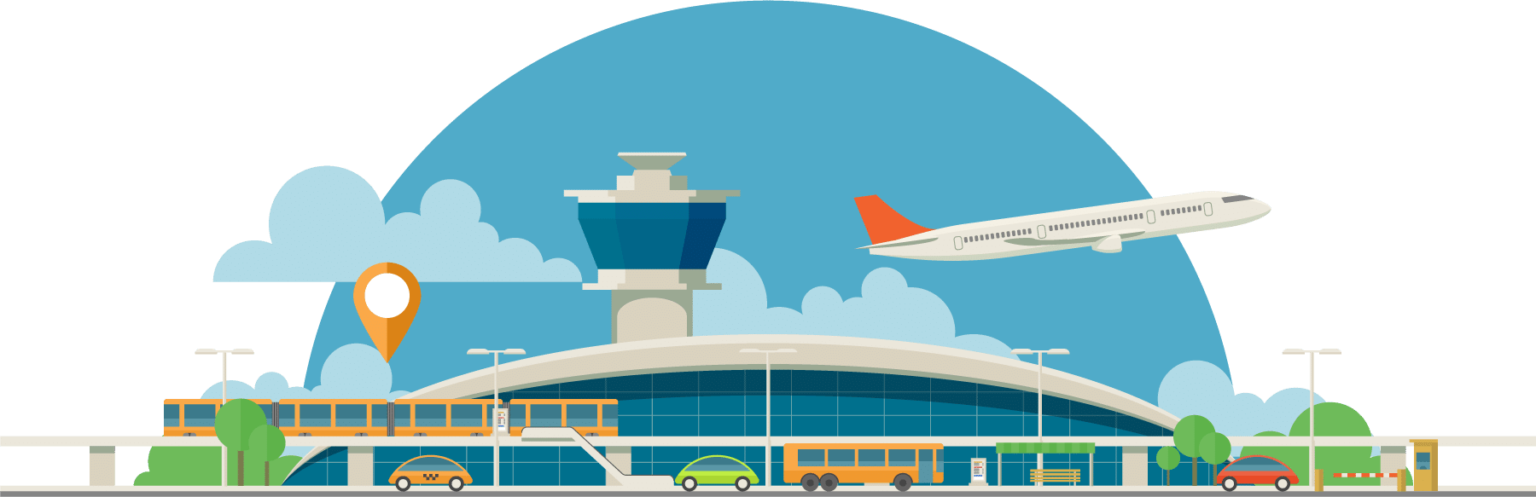

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [6]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
# !pip install xgboost
# !brew install cmake libomp
# !pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.5 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [1]:
import random
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import missingno
import time

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category = ConvergenceWarning)

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
# import lime
from lime.lime_tabular import LimeTabularExplainer

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [ ]:
!mkdir -p ~/.postgresql && \
    wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
        --output-document ~/.postgresql/root.crt && \
            chmod 600 ~/.postgresql/root.crt

--2023-12-29 01:09:37--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Распознаётся storage.yandexcloud.net (storage.yandexcloud.net)… 2a02:6b8::1d9, 213.180.193.243
Подключение к storage.yandexcloud.net (storage.yandexcloud.net)|2a02:6b8::1d9|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3579 (3,5K) [application/x-x509-ca-cert]
Сохранение в: «/Users/ivyuminov/.postgresql/root.crt»

/Users/ivyuminov/.p 100%[===================>]   3,50K  --.-KB/s    за 0s      

2023-12-29 01:09:37 (1,67 GB/s) - «/Users/ivyuminov/.postgresql/root.crt» сохранён [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

In [37]:
connect = psycopg2.connect(
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port="6432",
    sslmode="verify-full",
    dbname="db_flights", 
    user="mlhs_student", 
    password="mlhs_student",
    target_session_attrs="read-write"
    )

print("Подключение установлено")

df = pd.io.sql.read_sql_query(
    '''SELECT clients_flight_info.id, clients_flight_info."Customer Type", 
    clients_flight_info."Type of Travel", clients_flight_info.class, 
    clients_flight_info."Flight Distance", clients_flight_info."Departure Delay in Minutes", 
    clients_flight_info."Arrival Delay in Minutes", 
    clients_marks."Inflight wifi service", 
    clients_marks."Departure/Arrival time convenient", clients_marks."Ease of Online booking", 
    clients_marks."Gate location", clients_marks."Food and drink", 
    clients_marks."Online boarding", clients_marks."Seat comfort", 
    clients_marks."Inflight entertainment", clients_marks."On-board service", 
    clients_marks."Leg room service", clients_marks."Baggage handling", 
    clients_marks."Checkin service", clients_marks."Inflight service", 
    clients_marks.cleanliness, clients_marks.satisfaction, 
    clients_bio.gender, clients_bio.age
    FROM public.clients_flight_info 
    JOIN public.clients_marks ON clients_marks.id = public.clients_flight_info.id 
    JOIN public.clients_bio ON clients_bio.id = public.clients_flight_info.id''', 
    connect
    ).set_index('id')

connect.close()

df.to_csv('clients_flight_info.csv')

Подключение установлено


pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
```

### Схема БД

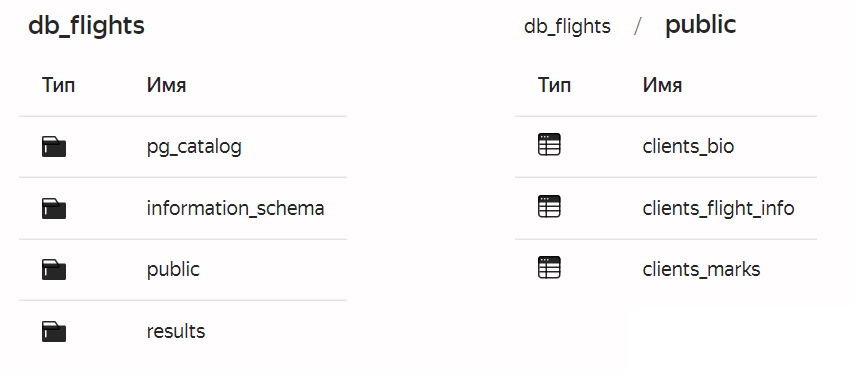

In [2]:
# df = pd.read_csv('clients_flight_info.csv').set_index('id')

In [41]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [42]:
df = df.replace(['nan'], np.nan) 

# пропуски
df.isna().sum()

Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
gender                                 0
age                                  315
dtype: int64

In [43]:
# поверяю действительные типы данных в колонкаx df, меняю на float, где применимо
def change_columns_type(data):

    dict_type_data = dict()
    for i in data.columns:
        try:
            element = data[i][1]
            element_float = float(element)
            dict_type_data[i] = type(element_float)
            data[i] = data[i].astype(float)
        except:
            dict_type_data[i] = type(data[i][1])

    return dict_type_data

# словарь типов данных колонок датафрейма
dict_type_df = change_columns_type(df)

# список переменных с типом данных float 
num_obj = [i for i in df.columns if (df[i].dtype == 'float')]

# список переменных с типом данных object
cat_obj = [i for i in df.columns if (df[i].dtype == 'object')]

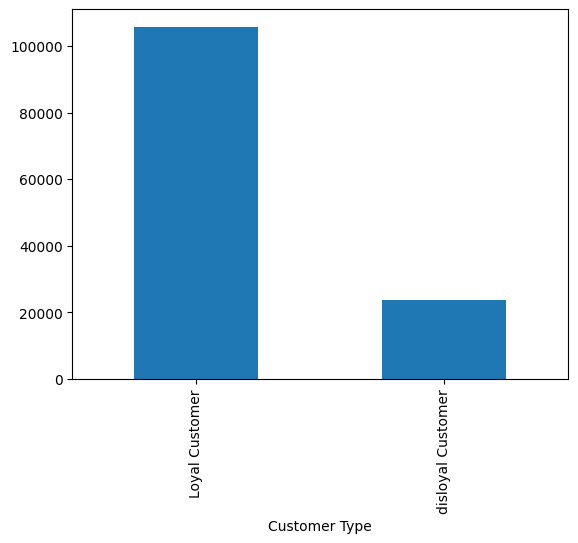

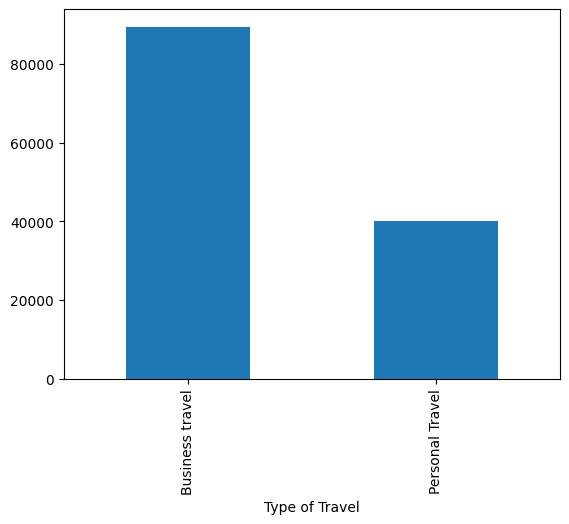

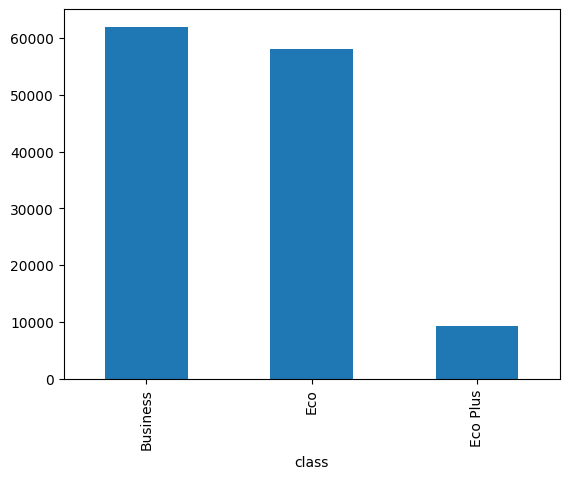

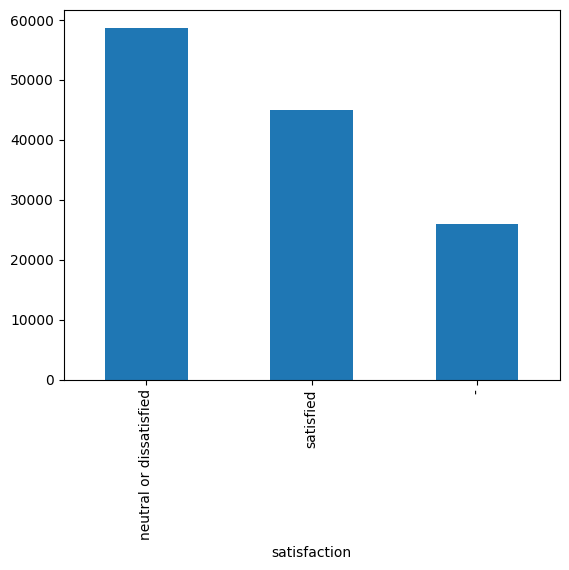

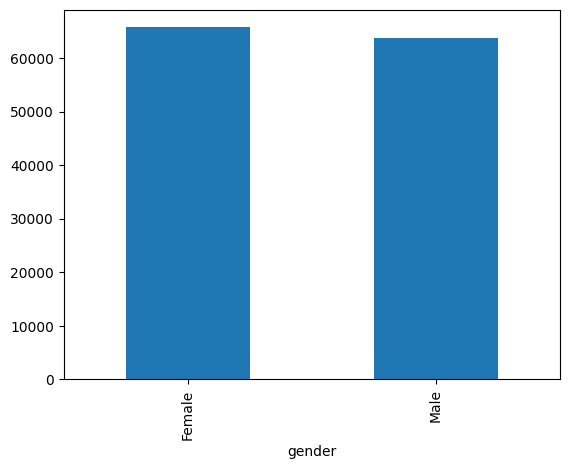

In [44]:
# распределение категориальных признаков
for i in cat_obj:
    df[i].value_counts().plot.bar()
    plt.show()

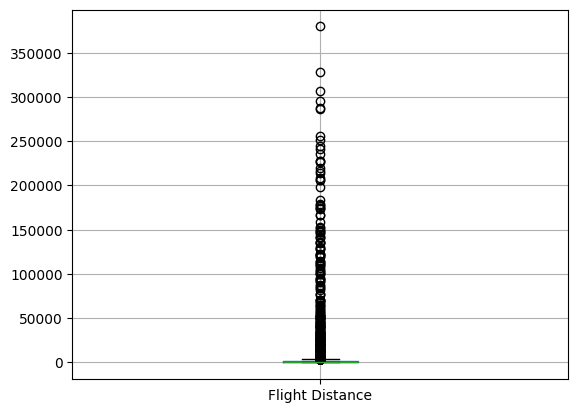

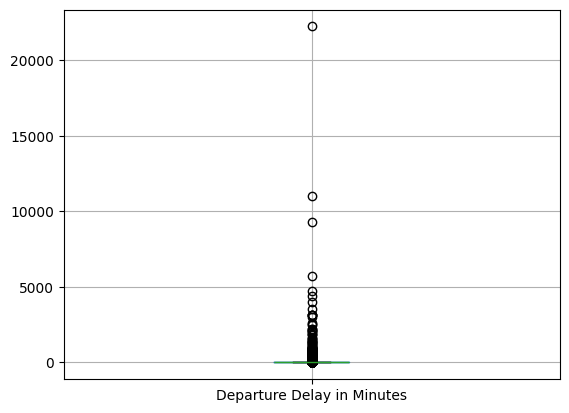

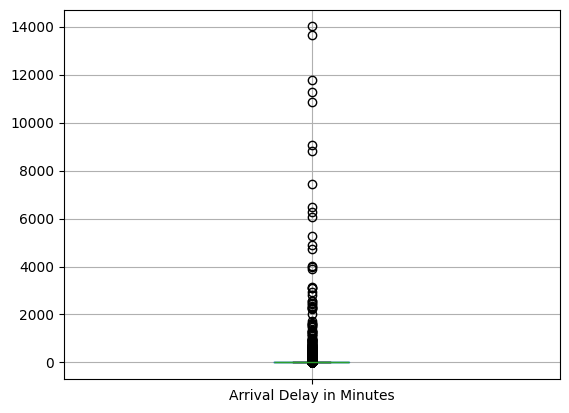

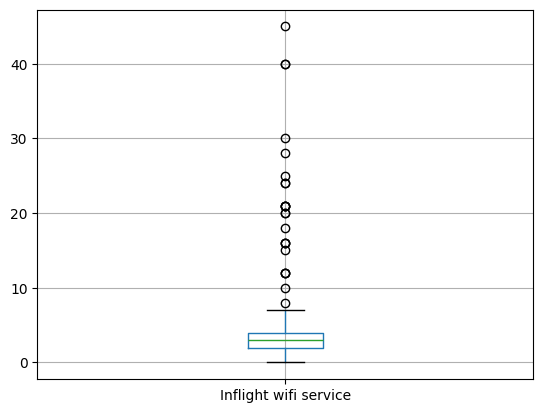

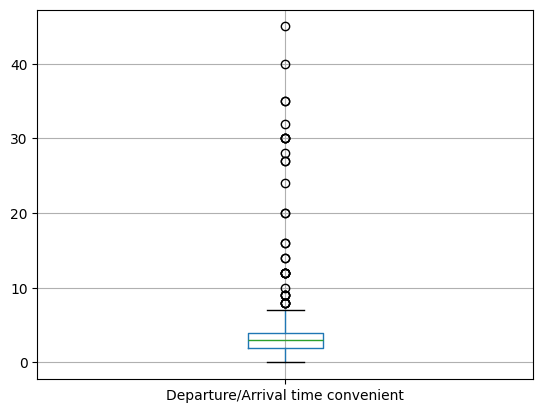

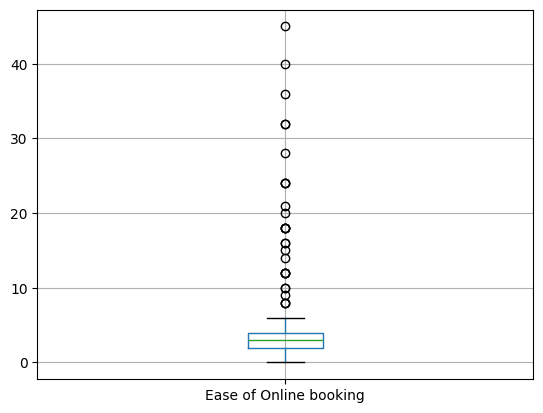

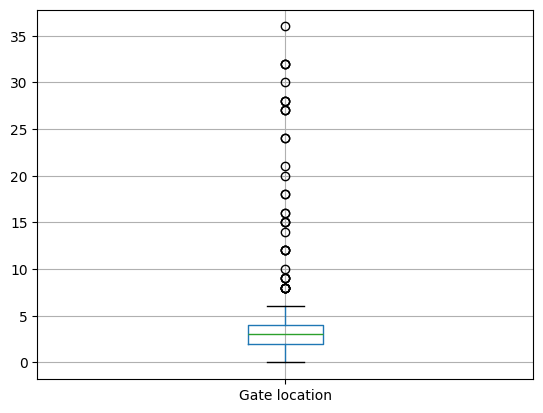

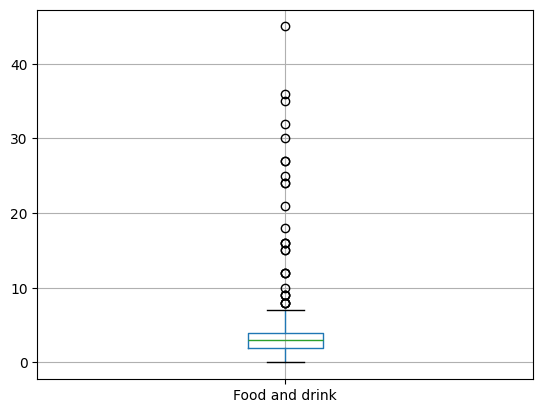

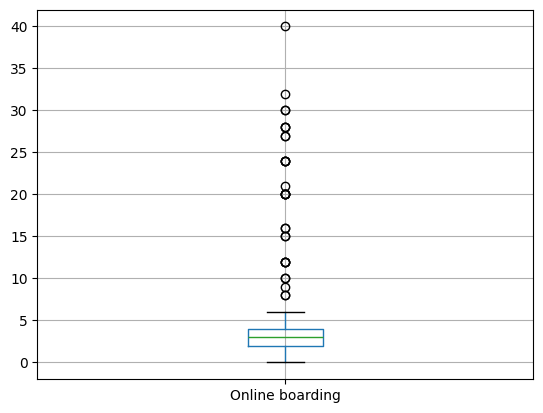

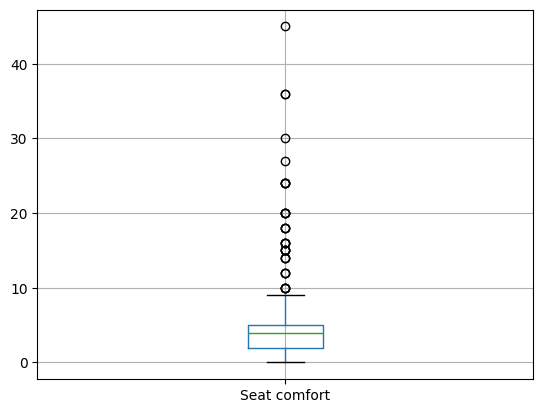

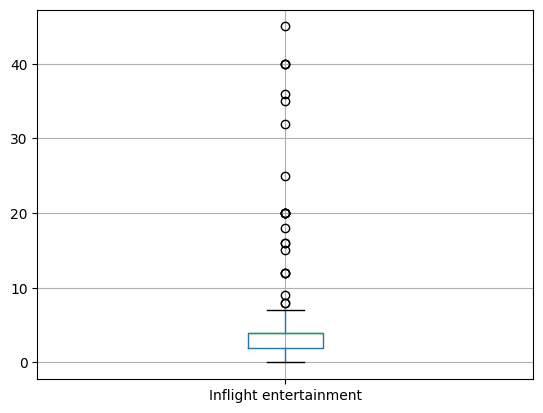

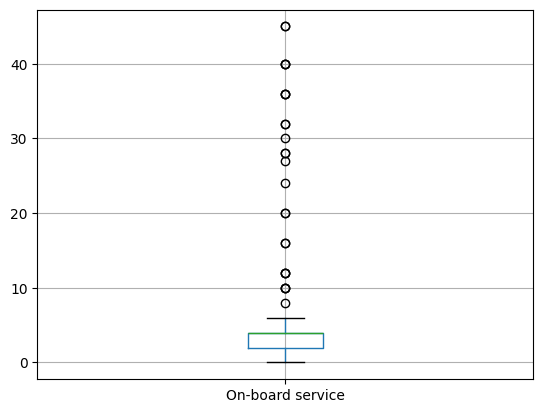

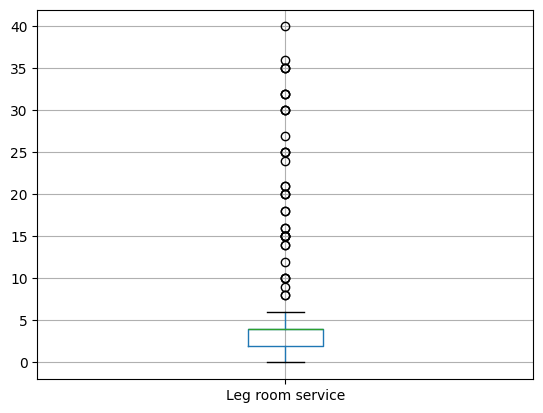

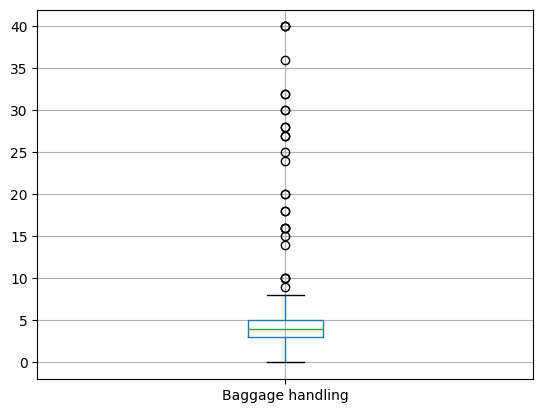

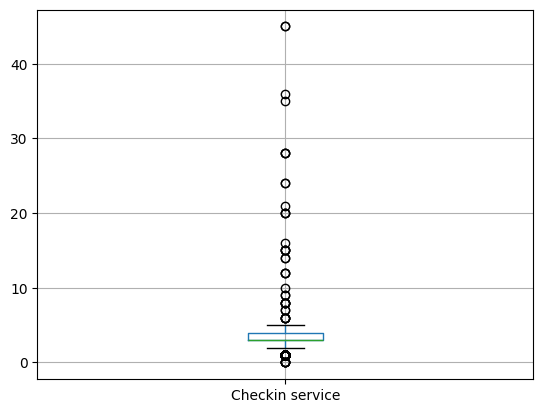

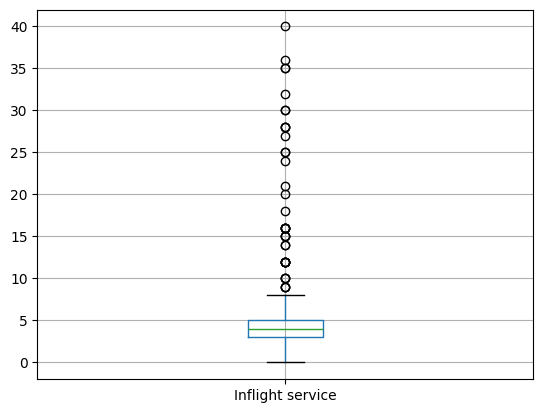

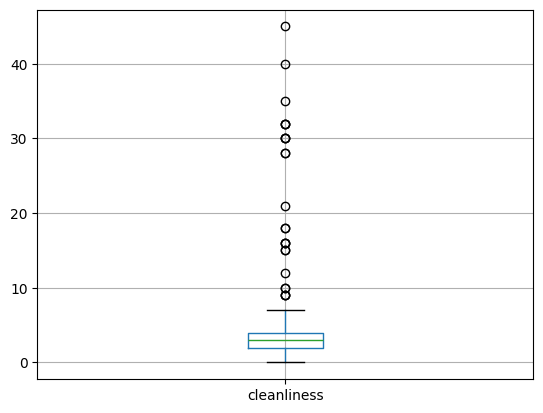

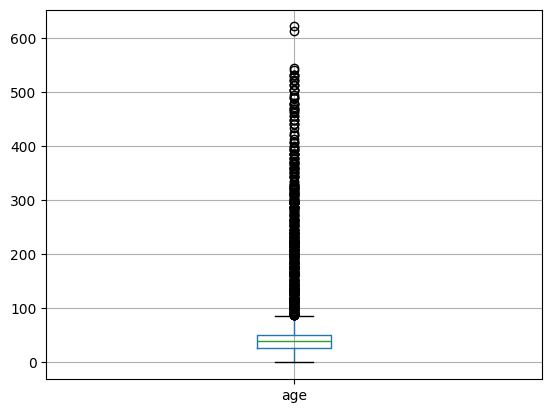

In [45]:
# распределение признаков с типом float
for i in num_obj:
    df.boxplot(column=[i])
    plt.show()

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

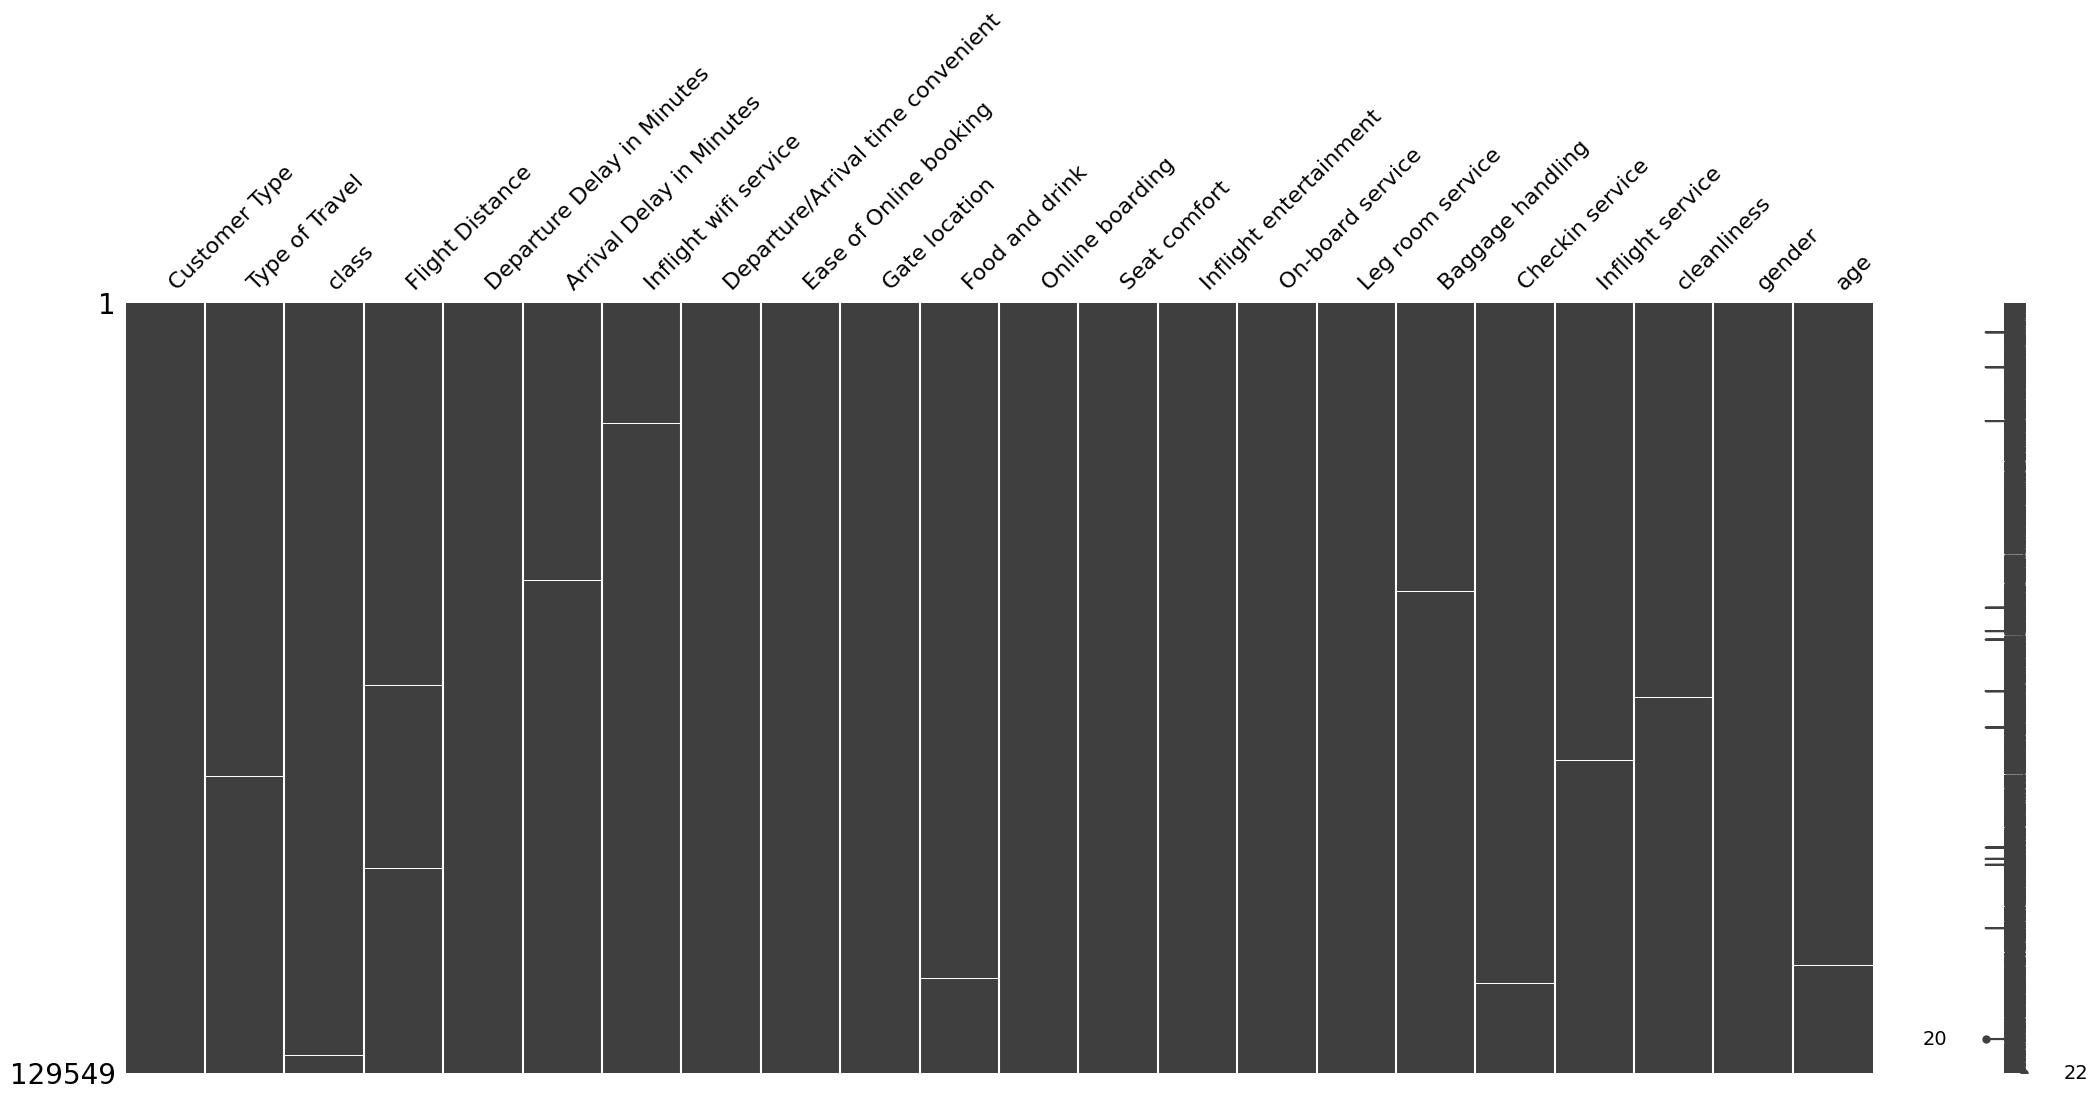

In [47]:
missingno.matrix(df.drop('satisfaction', axis='columns'));

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


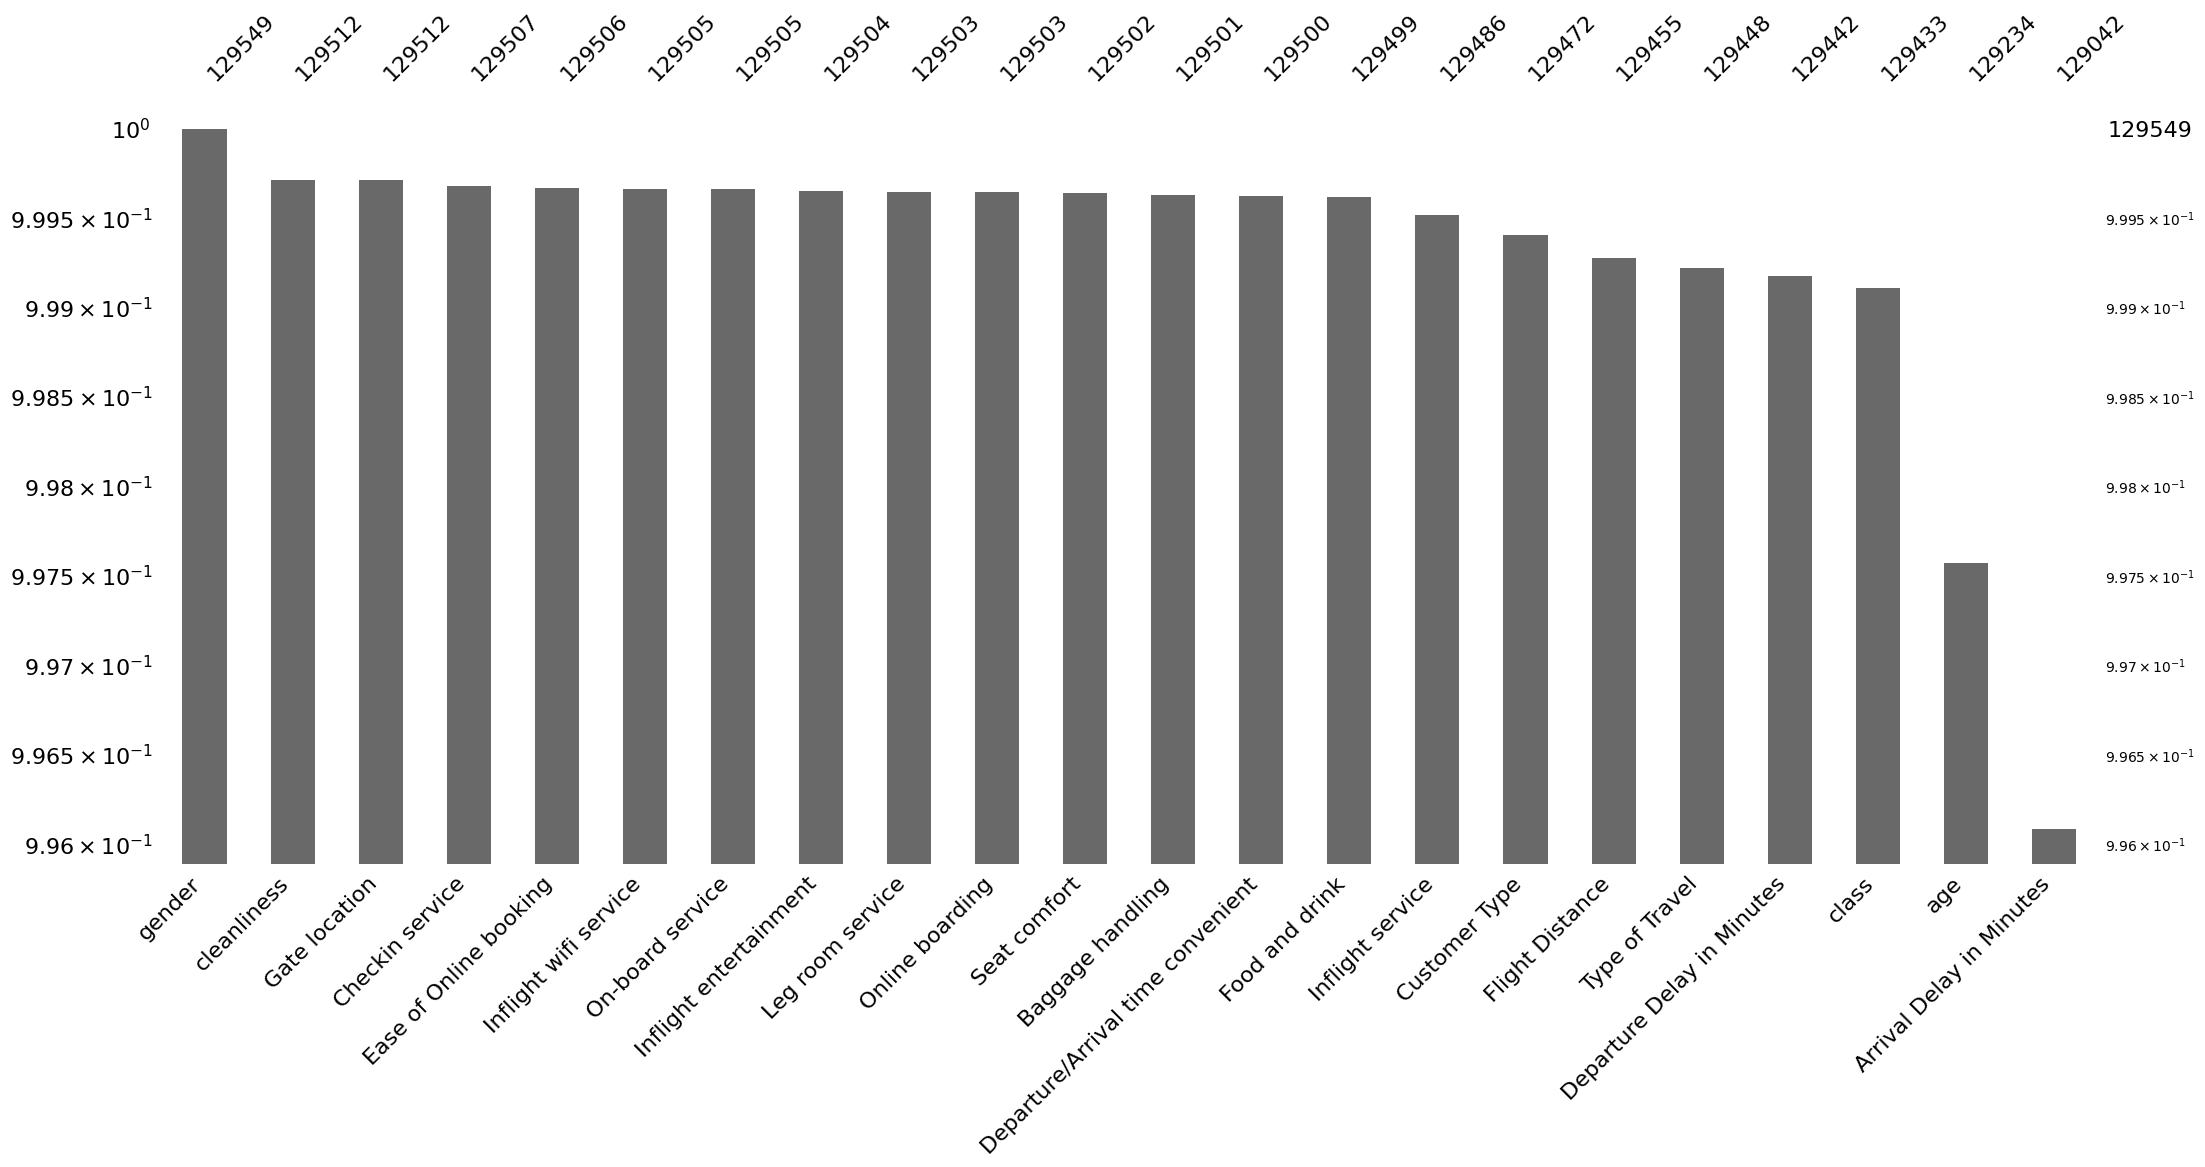

In [48]:
missingno.bar(df.drop('satisfaction', axis='columns'), log=True, sort="descending");

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [49]:
df_train = df[df.satisfaction != '-']

assert df_train.shape == (103_644, 23)

In [50]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)

assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [51]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis= 1), df_train.satisfaction, test_size=0.3, random_state=42)

assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [52]:
def fill_null_data(data, data_fill_null):
    
    '''
    data - данные по которым вычисляется значения для заполнения пропусков
    data_fill_null - данные в которых заполняются пропуски
    '''

    for column in data_fill_null.isna().sum().index:
        data_fill_null[column].fillna(data[column].mode()[0], inplace= True)

fill_null_data(X_train, X_train)
fill_null_data(X_train, X_val)
fill_null_data(X_train, df_test)

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [53]:
X_train.describe()

Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count     72550.000000                72550.000000              72550.000000   
mean       1329.018332                   15.859366                 16.645968   
std        4764.369357                   70.861937                 97.990293   
min           0.000000                    0.000000                  0.000000   
25%         413.000000                    0.000000                  0.000000   
50%         844.000000                    0.000000                  0.000000   
75%        1744.000000                   12.000000                 13.000000   
max      379620.000000                 9282.000000              11760.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count           72550.000000                       72550.000000   
mean                2.733687                           3.065017   
std                 1.362172                           1.552254   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                45.000000                          45.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            72550.000000   72550.000000    72550.000000     72550.000000   
mean                 2.761006       2.982688        3.209318         3.256513   
std                  1.414843       1.316648        1.349963         1.372739   
min                  0.000000       0.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         3.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                 28.000000      36.000000       36.000000        32.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  72550.000000            72550.000000      72550.000000   
mean       3.445665                3.362150          3.383101   
std        1.346077                1.360862          1.333758   
min        0.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max       45.000000               40.000000         45.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      72550.000000      72550.000000     72550.000000      72550.000000   
mean           3.352364          3.630255         3.309056          3.640234   
std            1.360180          1.227853         1.293114          1.215114   
min            0.000000          0.000000         0.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max           36.000000         40.000000        45.000000         36.000000   

        cleanliness           age  
count  72550.000000  72550.000000  
mean       3.291178     40.098856  
std        1.343302     20.658196  
min        0.000000      0.000000  
25%        2.000000     27.000000  
50%        3.000000     40.000000  
75%        4.000000     51.000000  
max       45.000000    544.000000

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

В распределении следующих признаков имеются явные выбросы, которые следует устранить:
* Flight Distance
* Departure Delay in Minutes
* Arrival Delay in Minutes
* age

Судя по разнице среднего значения и 50 процентиля (медиана) выбросы вносят существенный вклад. 

Оценки перелета по различным показателям, оценивались по 5-ти больной шкале, поэтому значения большие, чем 5, также можно считать выбросом. 

Распределение следующих категориальных переменных можно считать несбалансирвоанным между классами:
* Class
* Type of Travel
* Customer Type

Распределение целевой переменной Satisfaction тоже несбалансирвоанно. 

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [54]:
# очищаю от выбросов X_train
X_train['y'] = y_train
for i in num_obj:
    X_train = X_train[X_train[i] <= X_train[i].quantile(q= 0.996)]
y_train = X_train['y']
X_train.drop(['y'], axis= 1, inplace= True)

# очищаю от выбросов X_val
X_val['y'] = y_val
for i in num_obj:
    X_val = X_val[X_val[i] <= X_val[i].quantile(q= 0.996)]
y_val = X_val['y']
X_val.drop(['y'], axis= 1, inplace= True)

In [55]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [56]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(X_train.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(X_train.select_dtypes(include='object').columns)[:-1]
categorical_cols.append('gender')

In [57]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [58]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for column in cols:
        plt.figure(figsize=(9, 5))
        plot = sns.countplot(df, x= column, hue= y)
        plot.set_title(f"{column} distribution", fontdict={'size': 10})
        plt.legend(prop= {"size": 7})
        plt.show()

In [59]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row 
    for all columns in 'cols' with informative title 
    """
    for column in cols:
        fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize= [10, 5])
        plot = sns.kdeplot(data=df, x= column, hue= y, ax= axs[0])
        plot.set_title(f"{column} distribution", fontdict={'size': 10})
        
        axs[1].set_title(f"{column} boxplot by target", fontdict={'size': 10})
        sns.boxplot(data= df, x= column, y= y, hue= y, ax= axs[1])
        plt.yticks(rotation= 90)
        plt.show()

In [61]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for column in cols:
        plt.figure(figsize=(9, 5))
        plot = sns.countplot(df, x= column, hue= y)
        plot.set_title(f"{column} distribution", fontdict={'size': 10})
        plt.legend(prop= {"size": 7})
        plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

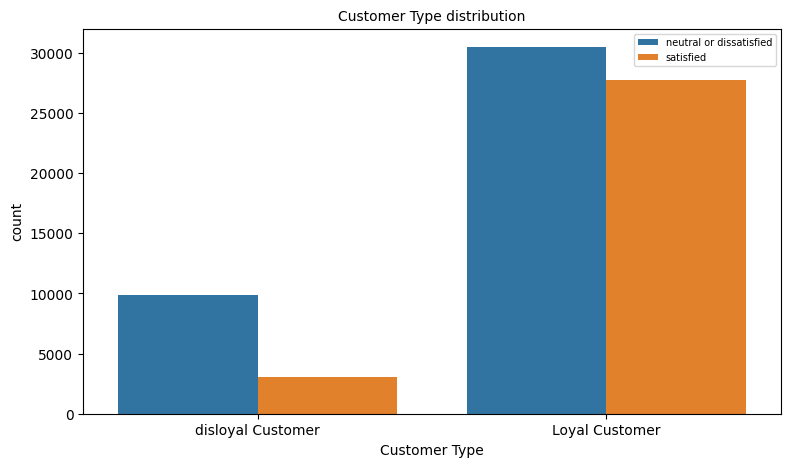

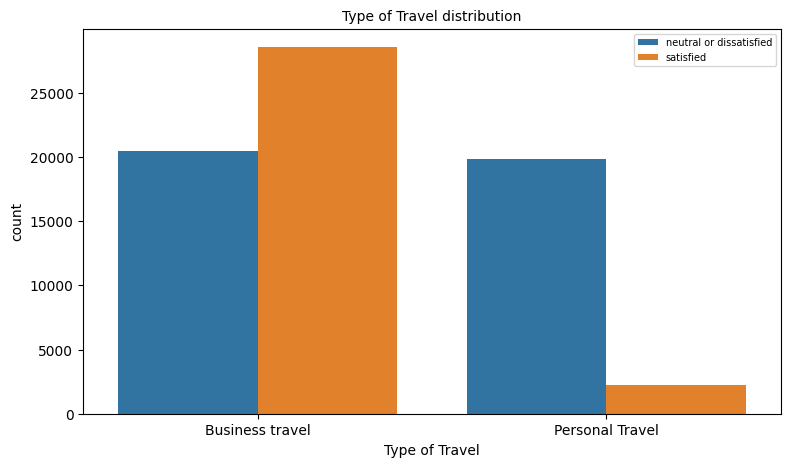

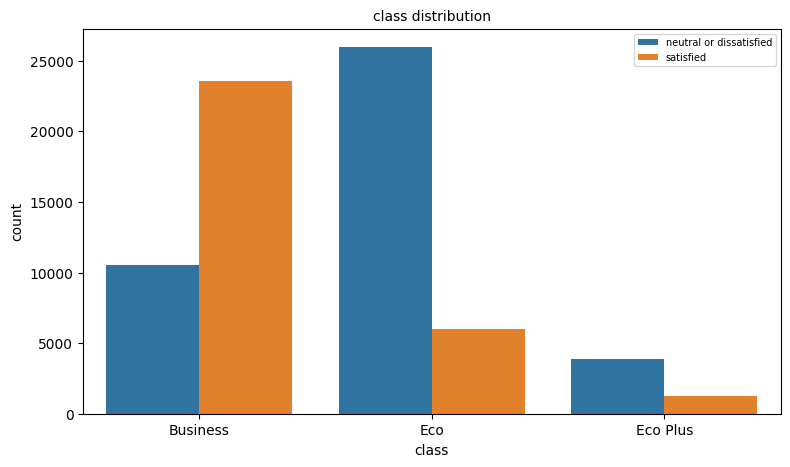

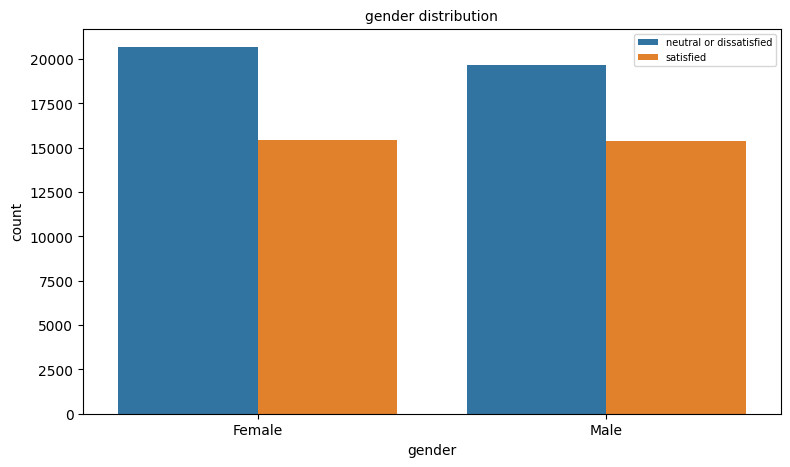

In [62]:
plot_categorical(categorical_cols, X_train, y_train)

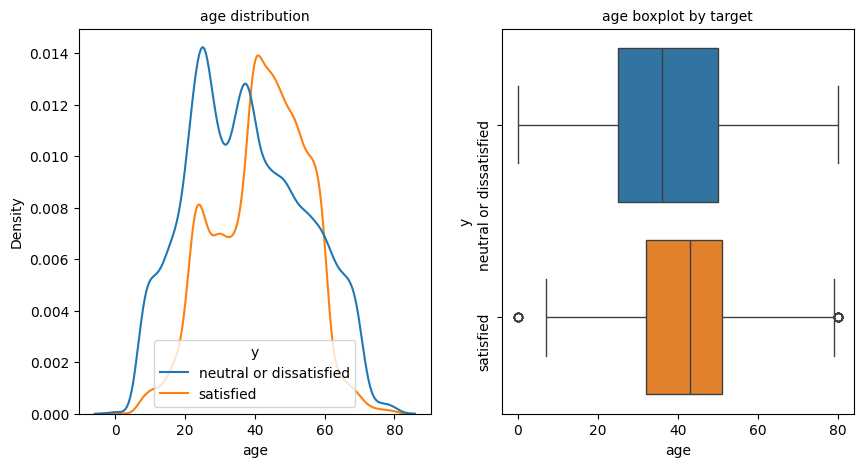

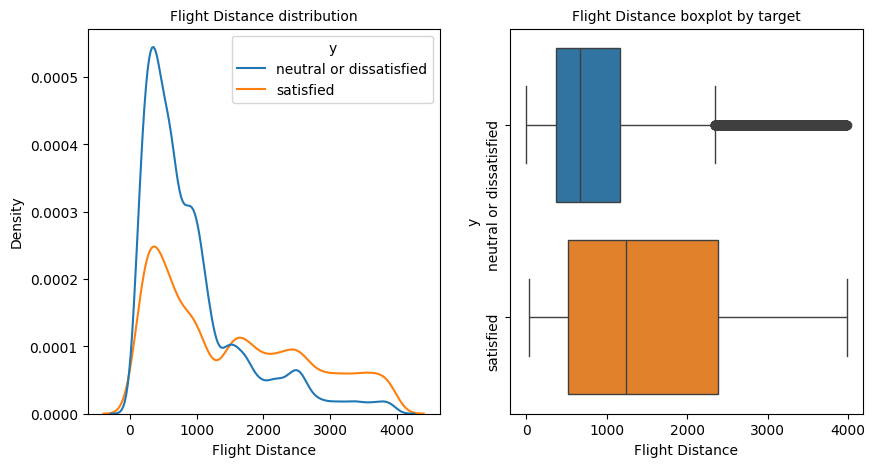

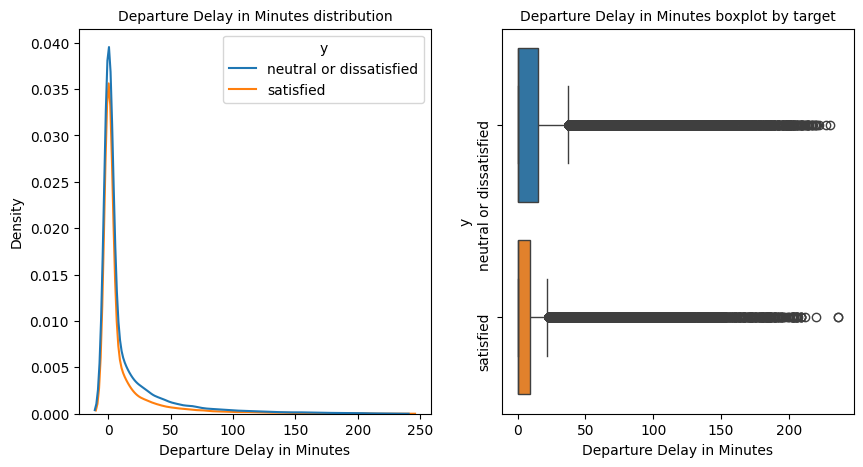

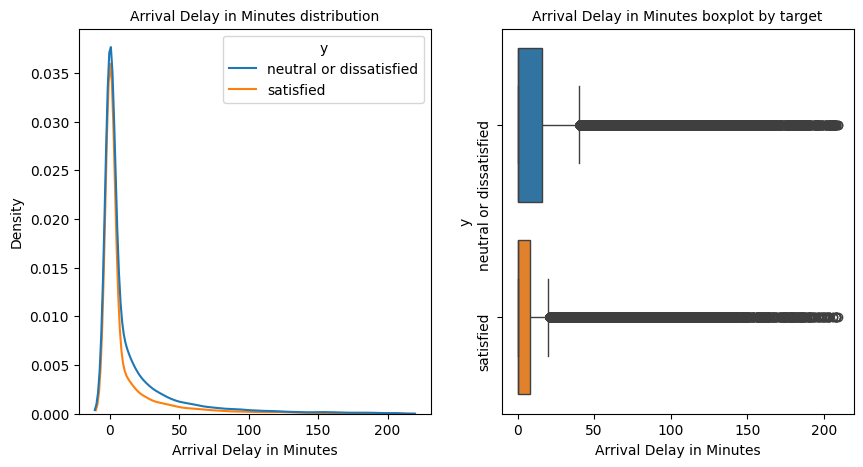

In [63]:
plot_continuous(continuous_cols, X_train, y_train)

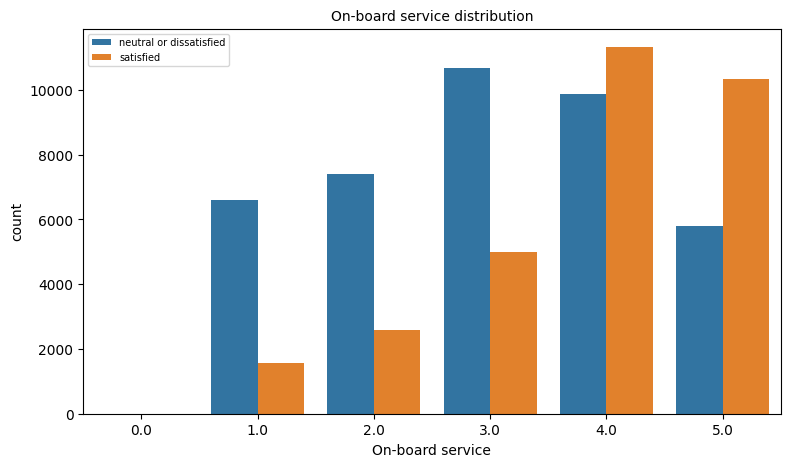

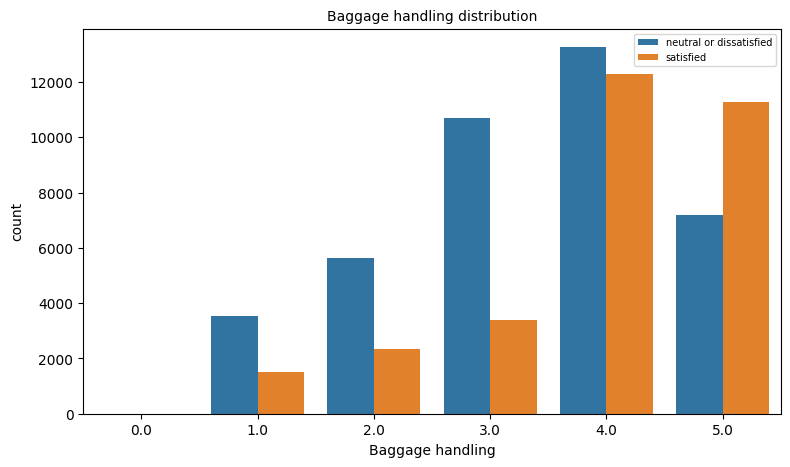

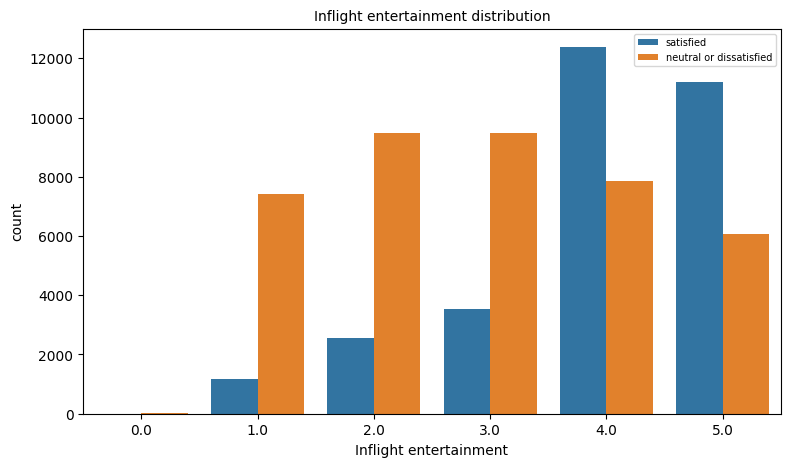

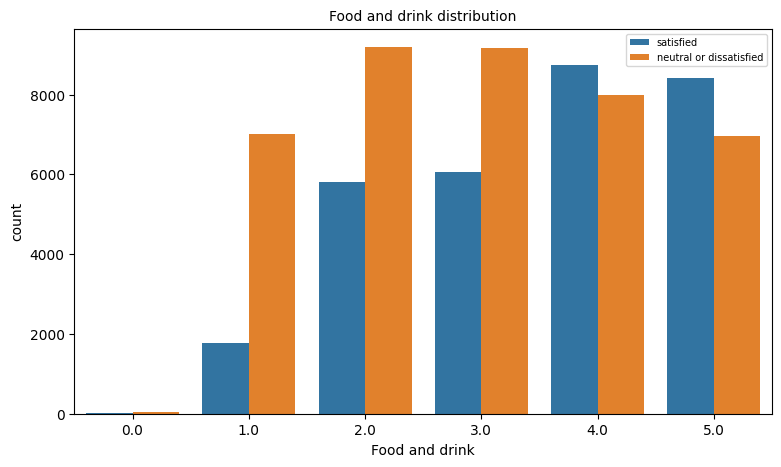

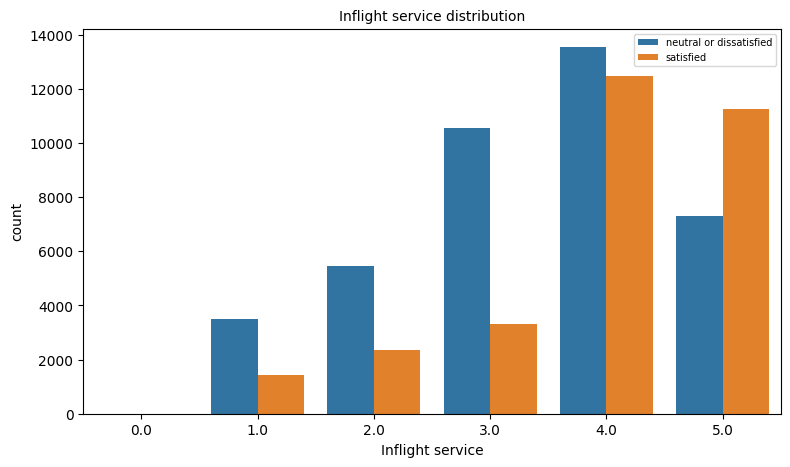

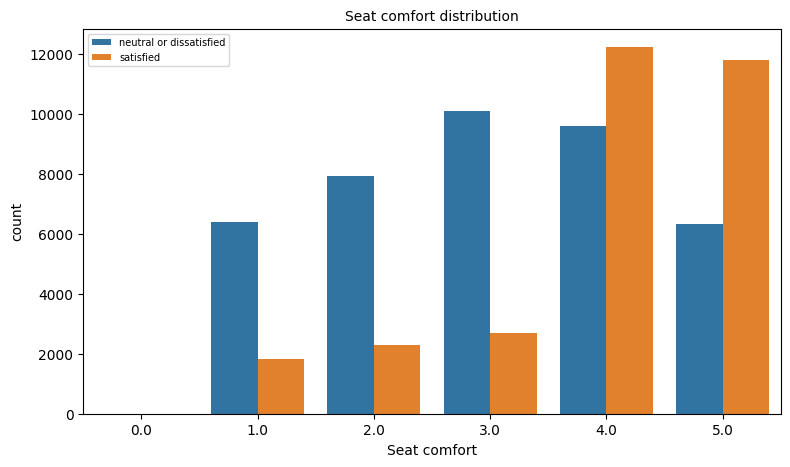

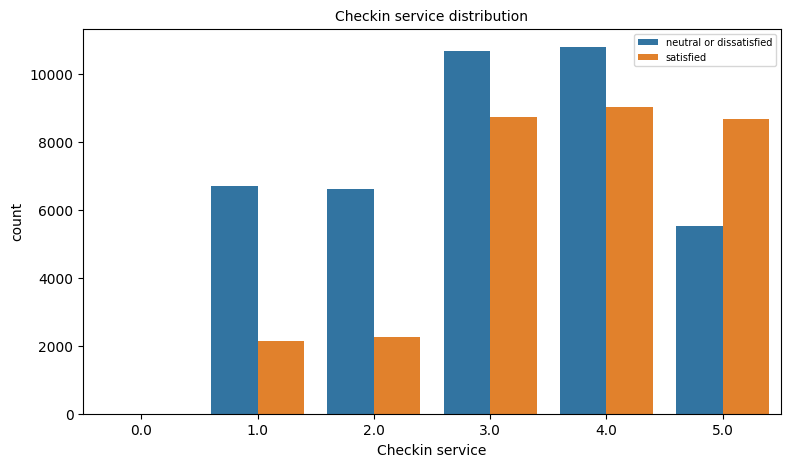

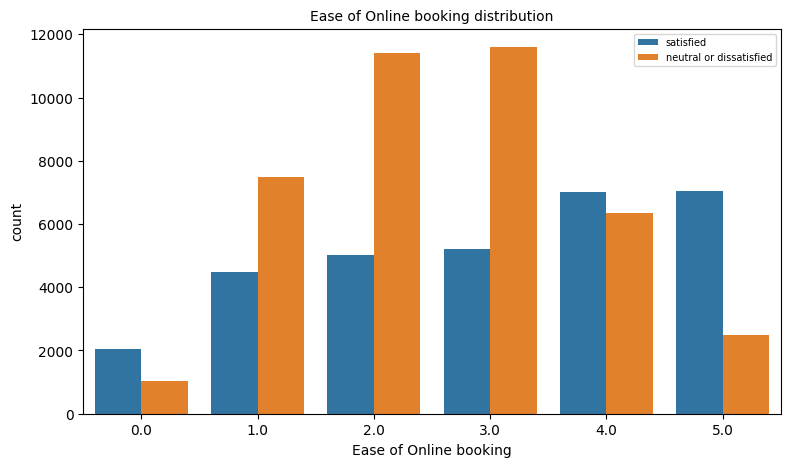

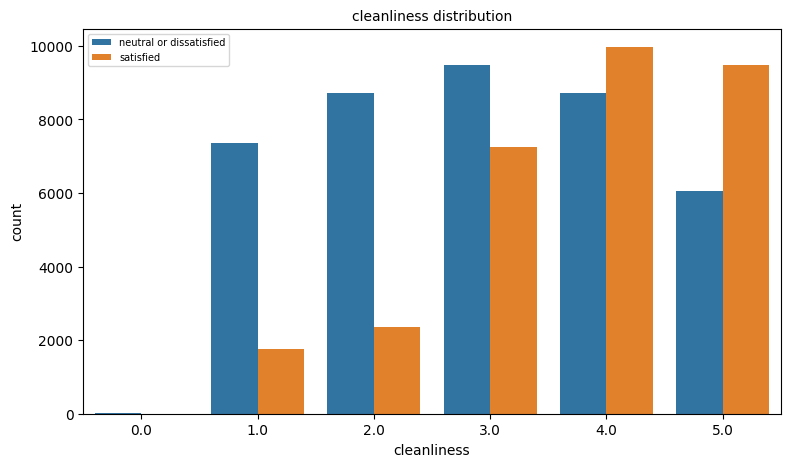

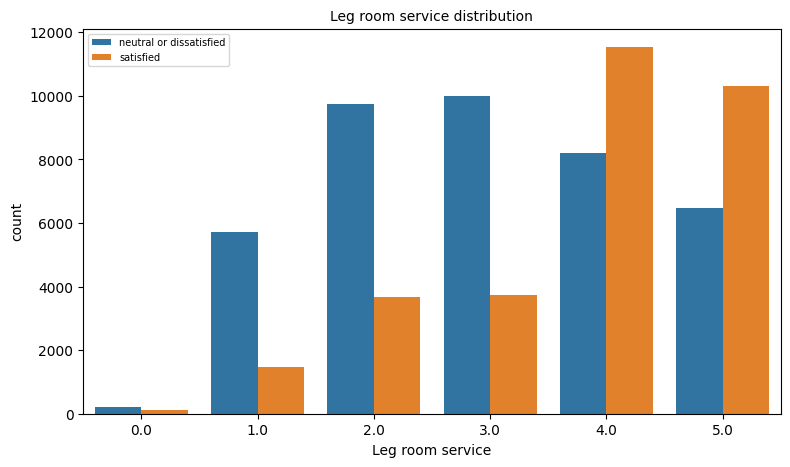

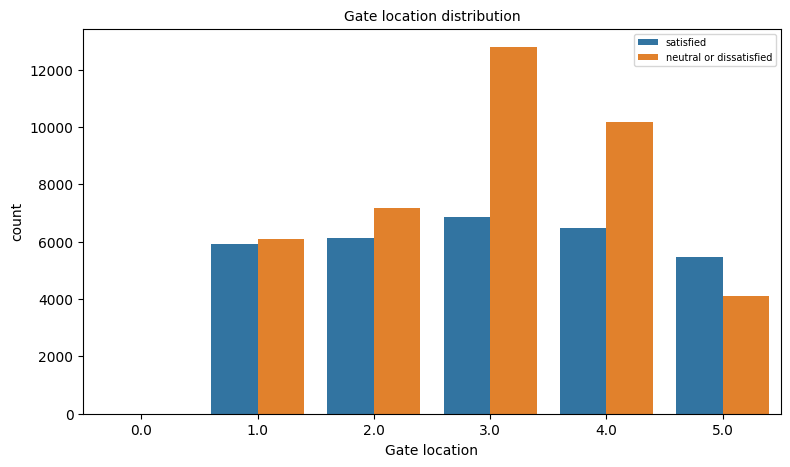

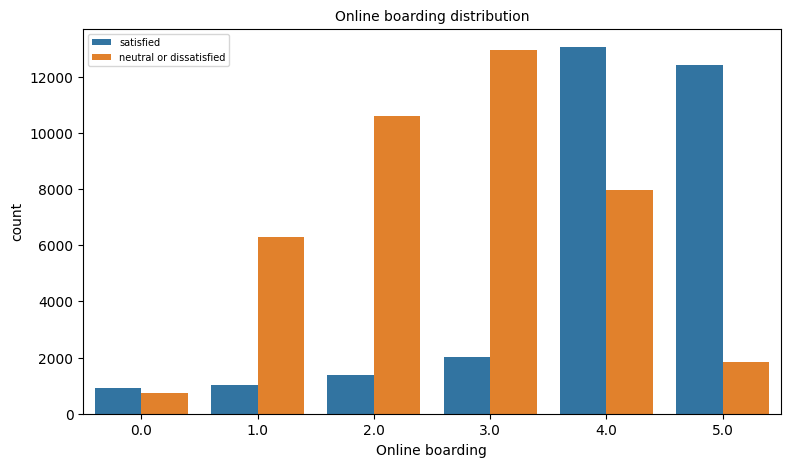

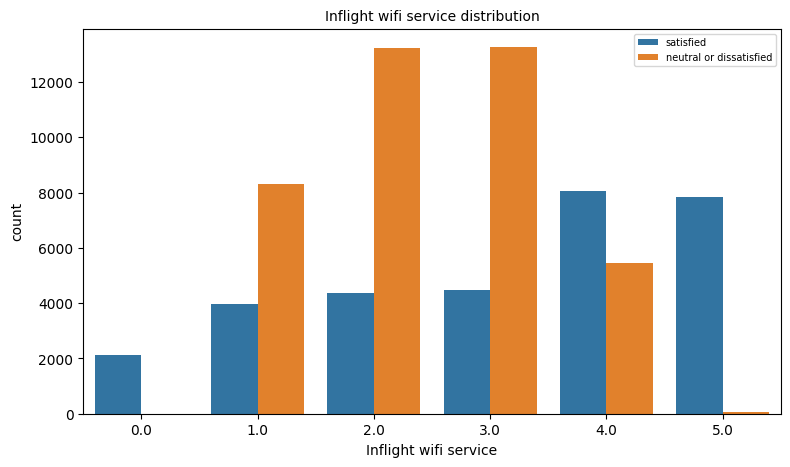

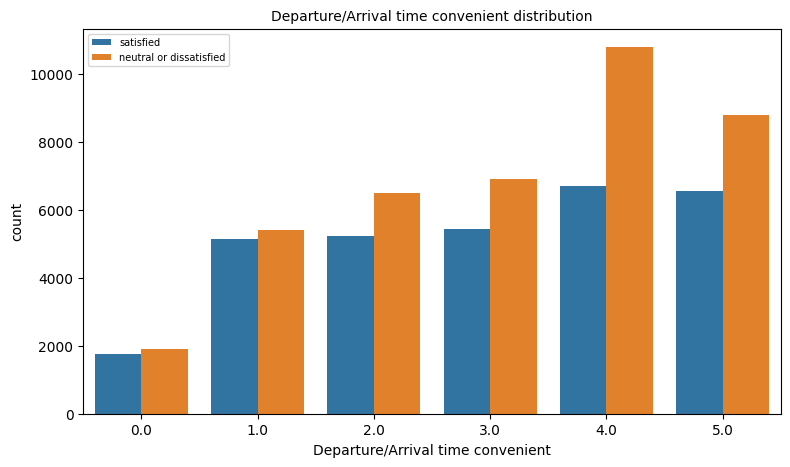

In [64]:
plot_ordinal(ordinal_cols, X_train, y_train)

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

- Можно сказать, что большинство признаков распределены неравномерно
- Максимально низкие оценки пассажиры ставят редко
- Класс полета "Eco plus" пользуется наименьшей популярностью из остальных 
- Классы несбалансированы 
- Распределеие возраста имеет двумодальный характер, 
- Распределение времени задержки прибытия и времени отправления рейсов имеет форму распределения Фишера
- Распределение расстояния имеет одномодальный характер 

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

<Figure size 1000x500 with 0 Axes>

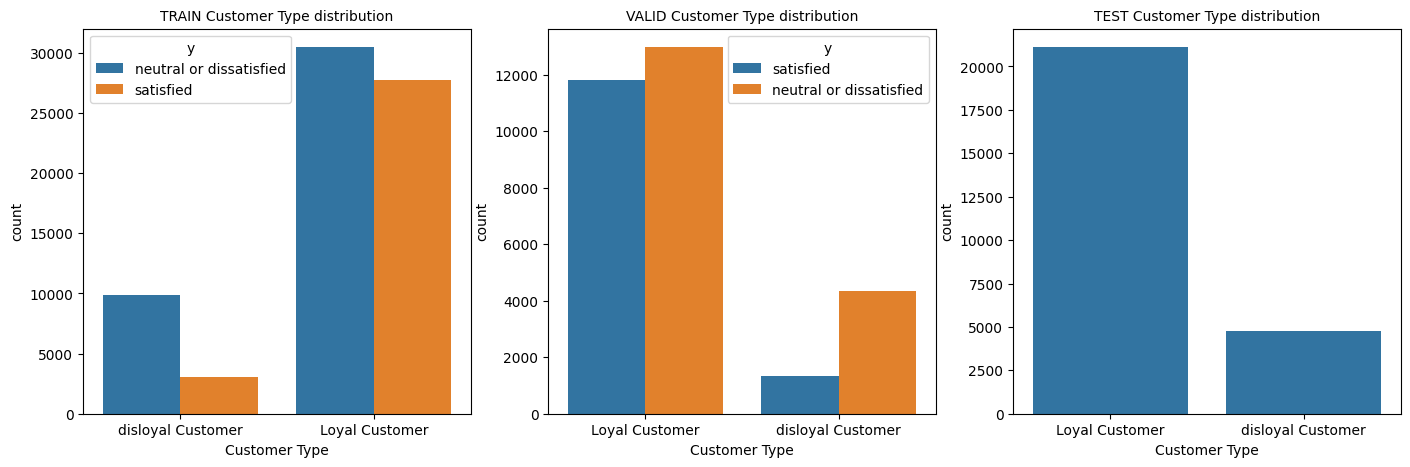

<Figure size 1000x500 with 0 Axes>

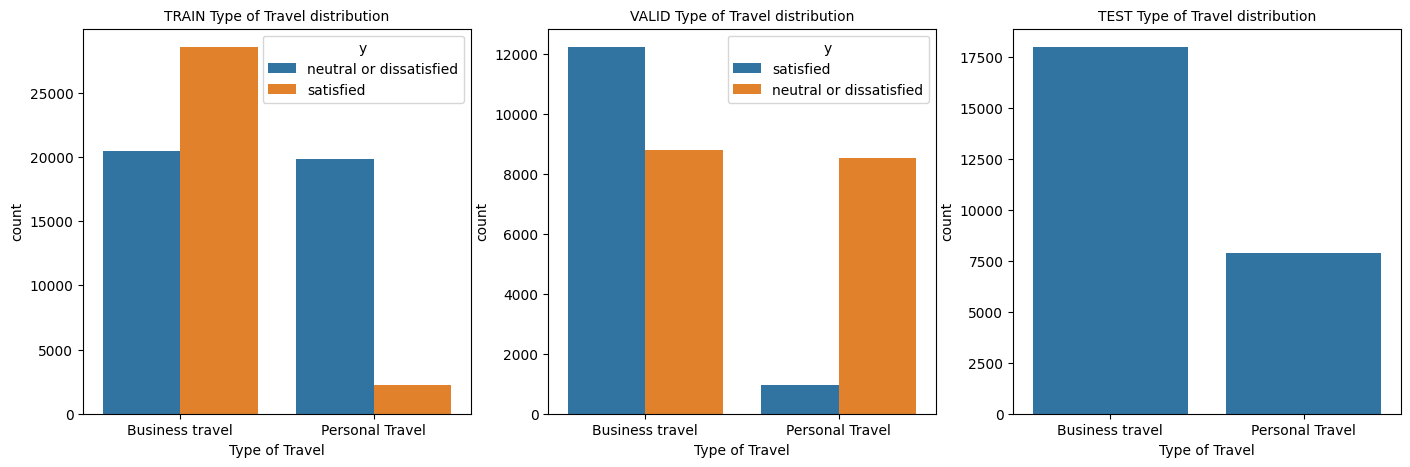

<Figure size 1000x500 with 0 Axes>

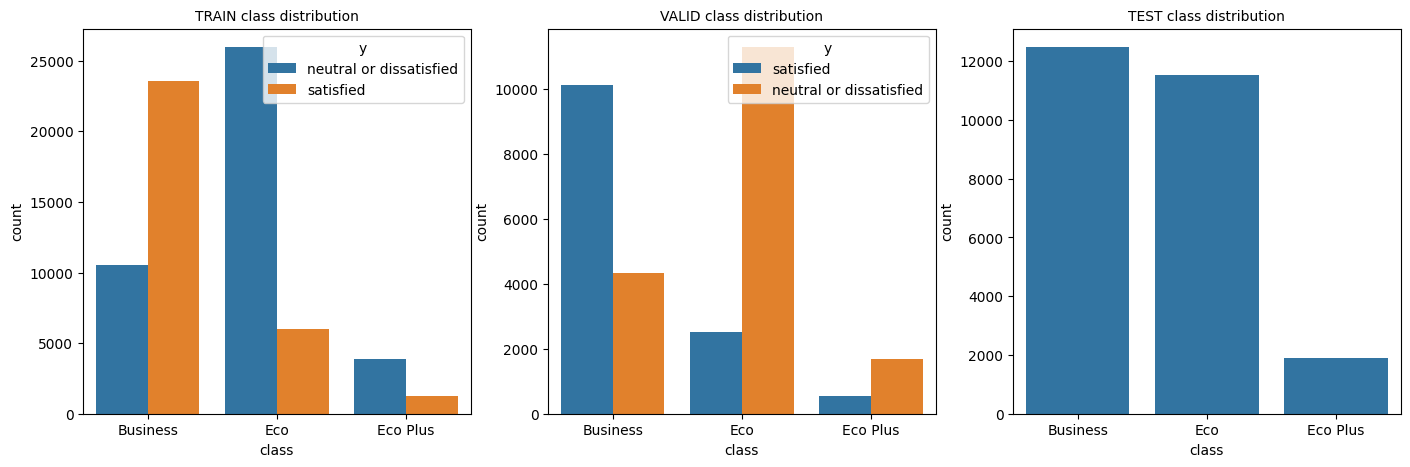

<Figure size 1000x500 with 0 Axes>

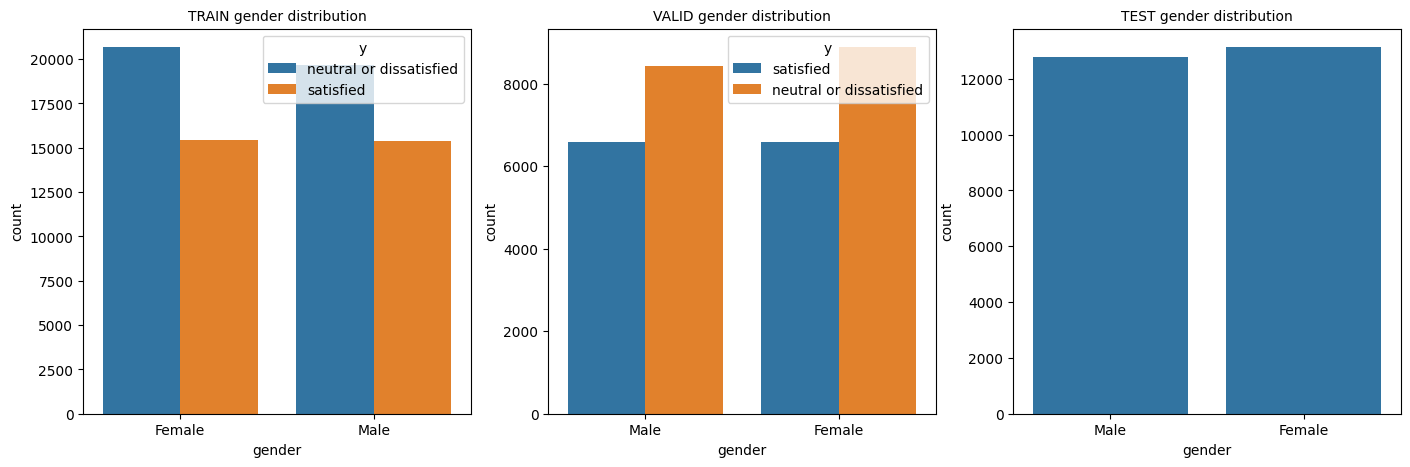

In [65]:
def plot_categorical(cols, df, y, df_valid, y_valid, test):
    """Draws countplots for all columns in 'cols' with informative title"""
    for column in cols:
        plt.figure(figsize=(10, 5))
        fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize= [17, 5])
        plot = sns.countplot(df, x= column, hue= y, ax= axs[0])
        plot.set_title(f"TRAIN {column} distribution", fontdict={'size': 10})

        plot = sns.countplot(df_valid, x= column, hue= y_valid, ax= axs[1])
        plot.set_title(f"VALID {column} distribution", fontdict={'size': 10})

        plot = sns.countplot(test, x= column, ax= axs[2])
        plot.set_title(f"TEST {column} distribution", fontdict={'size': 10})
        plt.show();

plot_categorical(categorical_cols, X_train, y_train, X_val, y_val, df_test)

<Figure size 900x500 with 0 Axes>

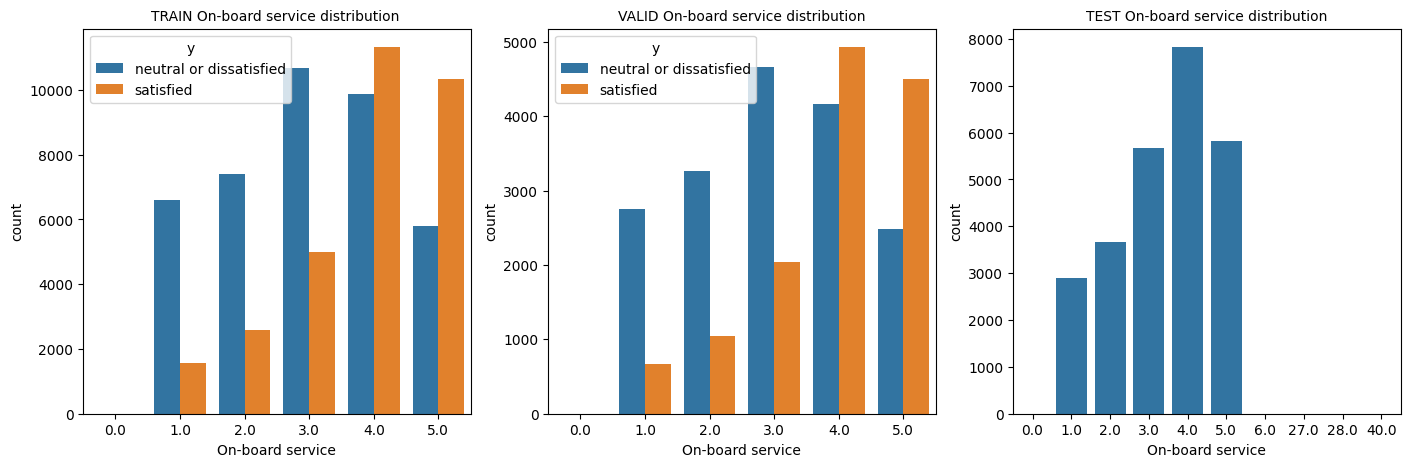

<Figure size 900x500 with 0 Axes>

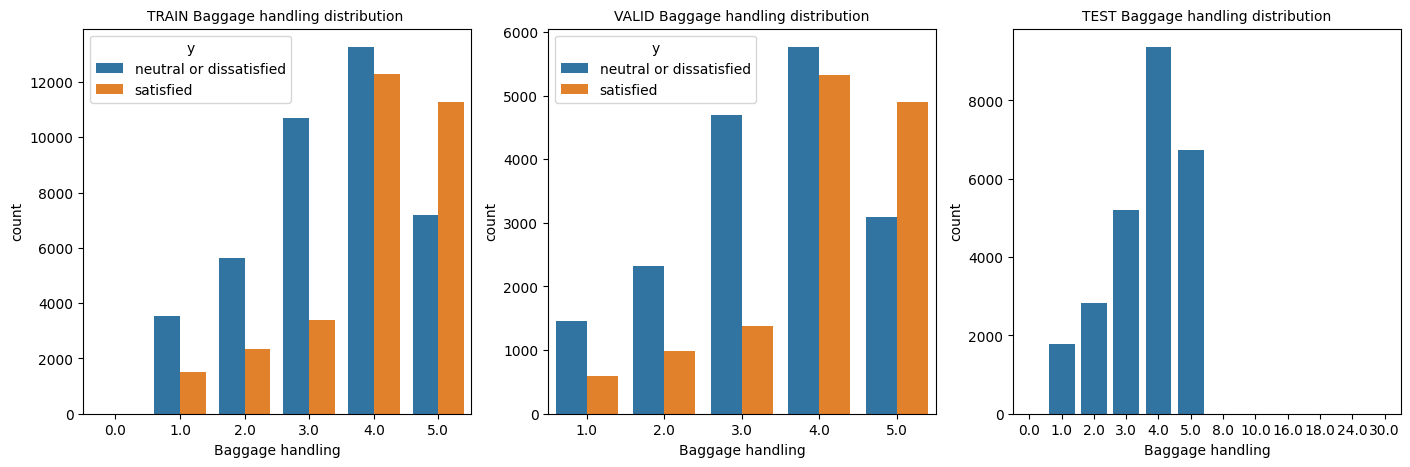

<Figure size 900x500 with 0 Axes>

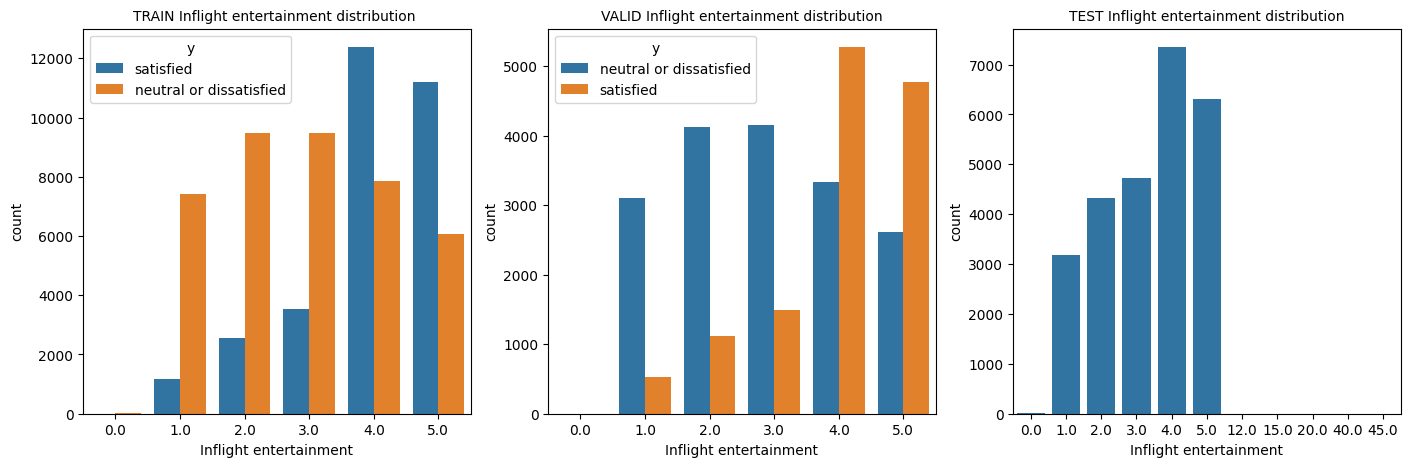

<Figure size 900x500 with 0 Axes>

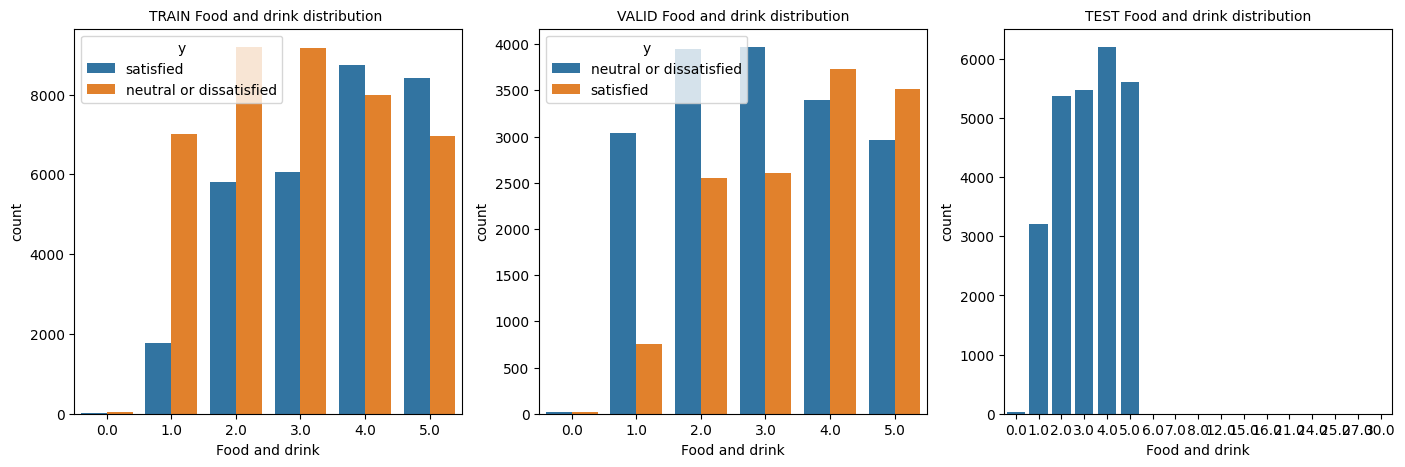

<Figure size 900x500 with 0 Axes>

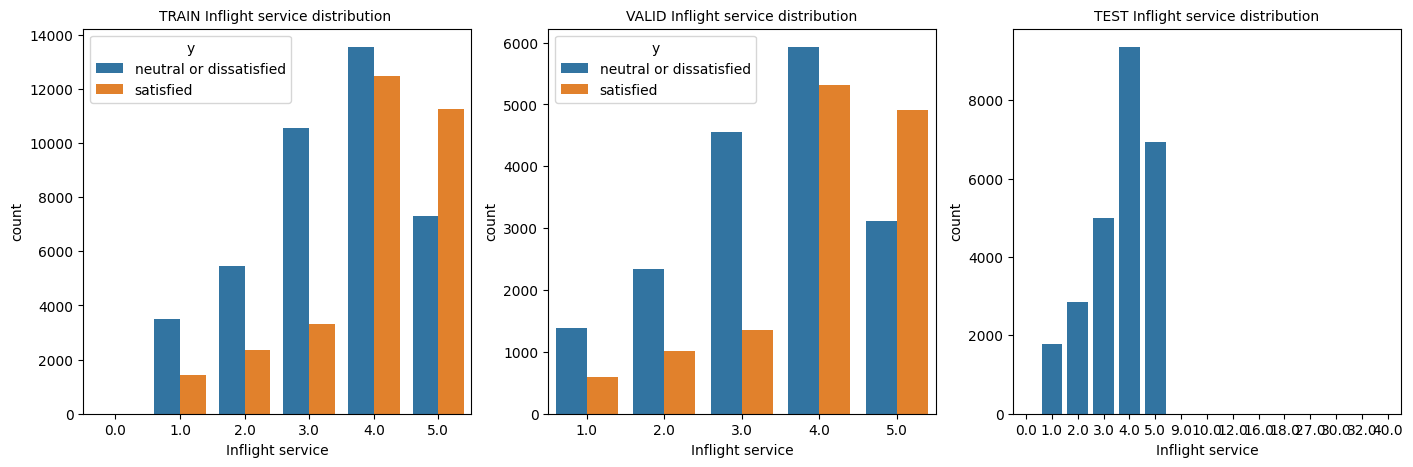

<Figure size 900x500 with 0 Axes>

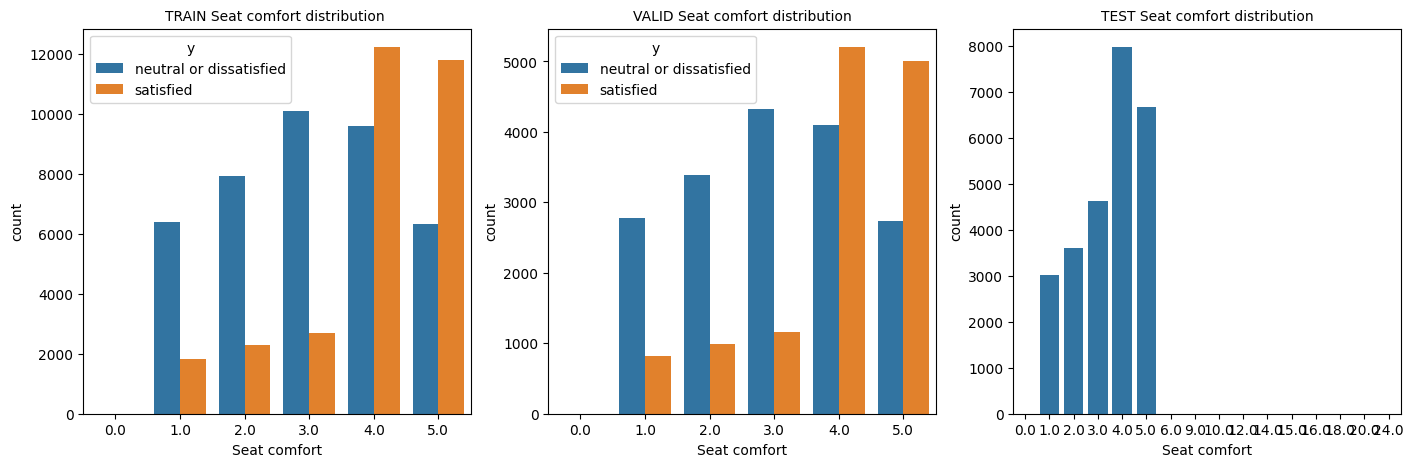

<Figure size 900x500 with 0 Axes>

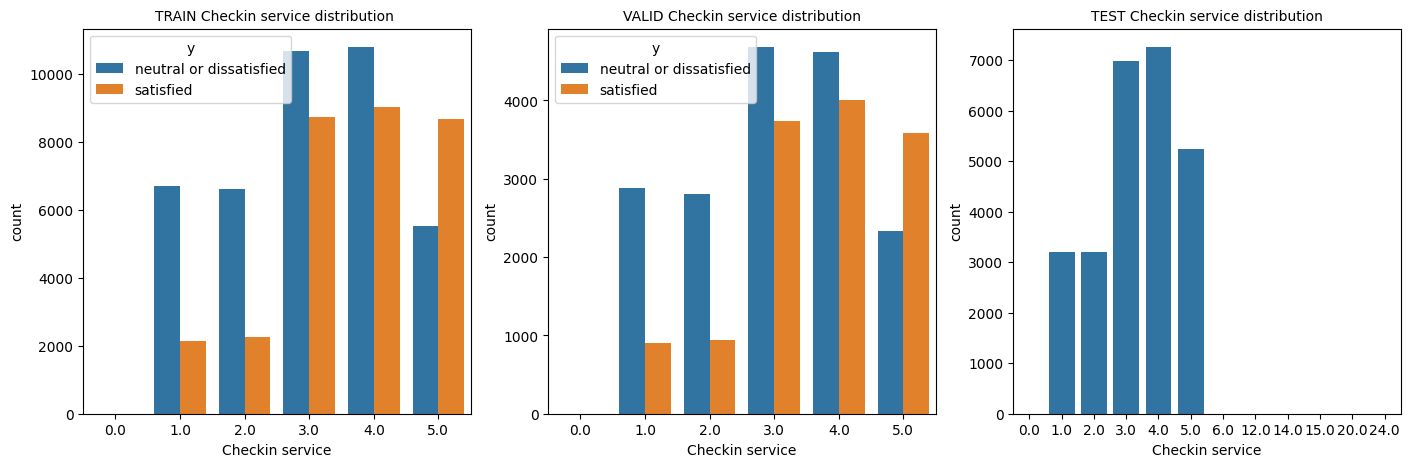

<Figure size 900x500 with 0 Axes>

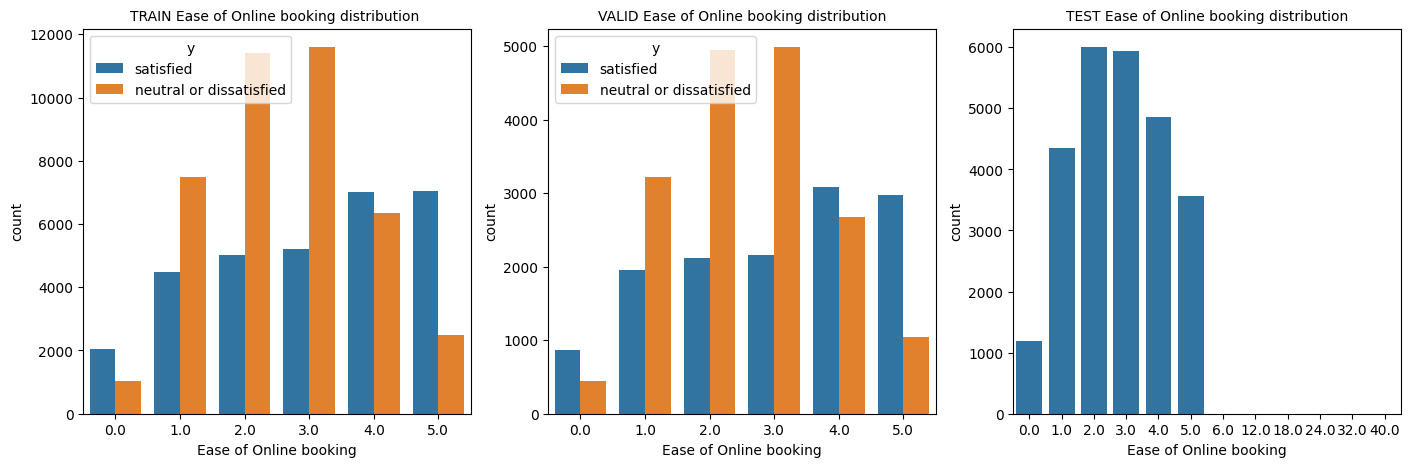

<Figure size 900x500 with 0 Axes>

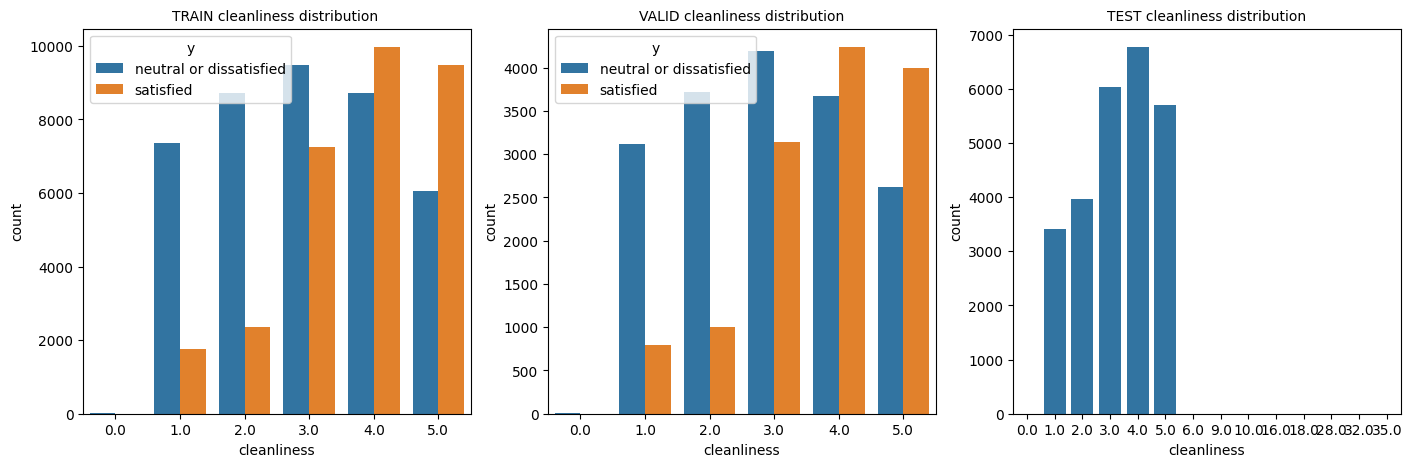

<Figure size 900x500 with 0 Axes>

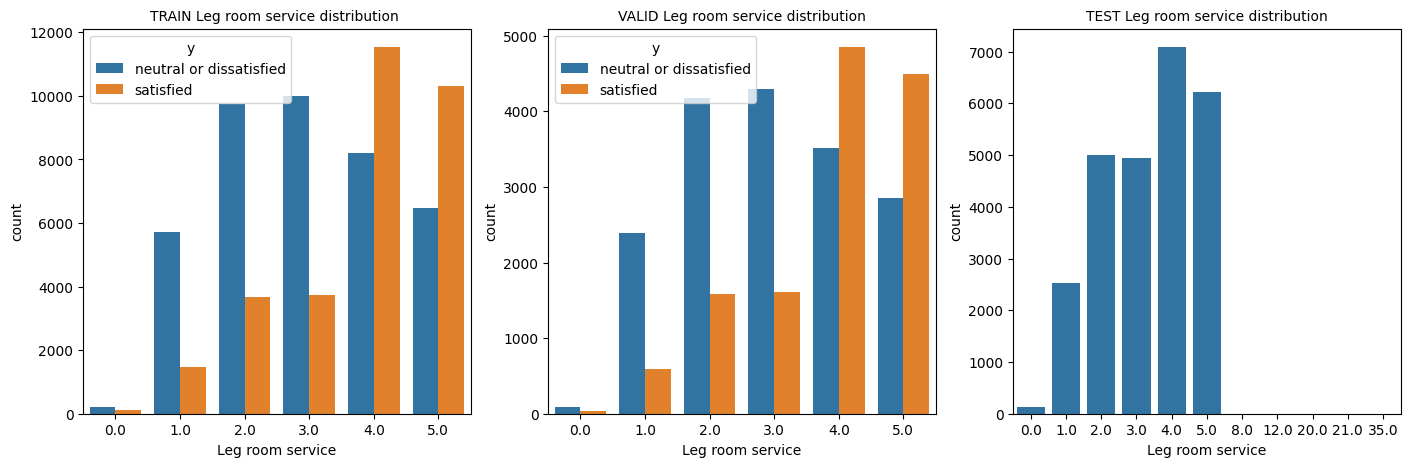

<Figure size 900x500 with 0 Axes>

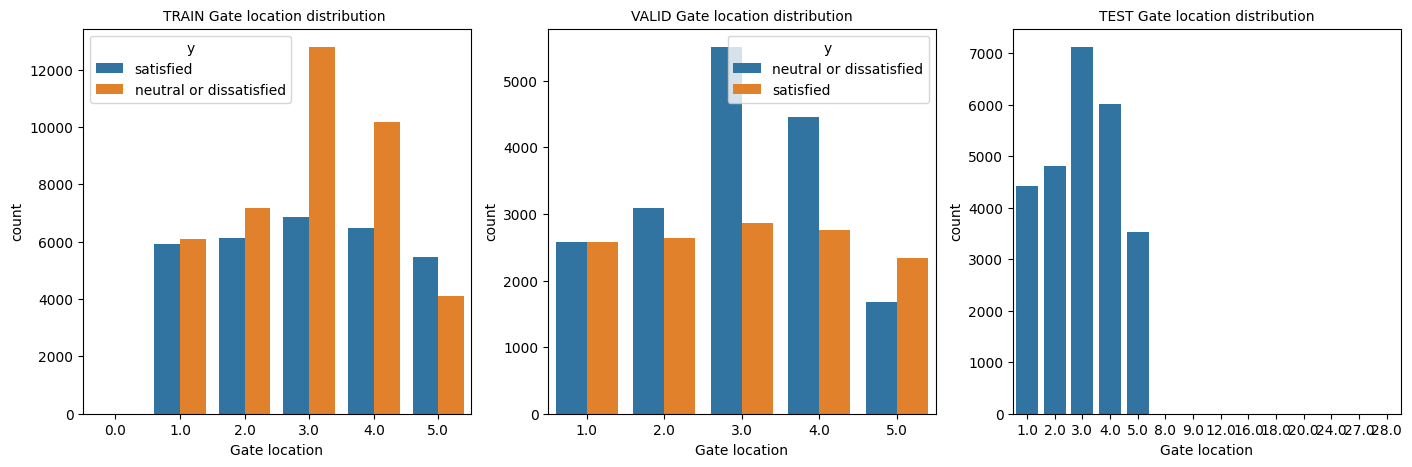

<Figure size 900x500 with 0 Axes>

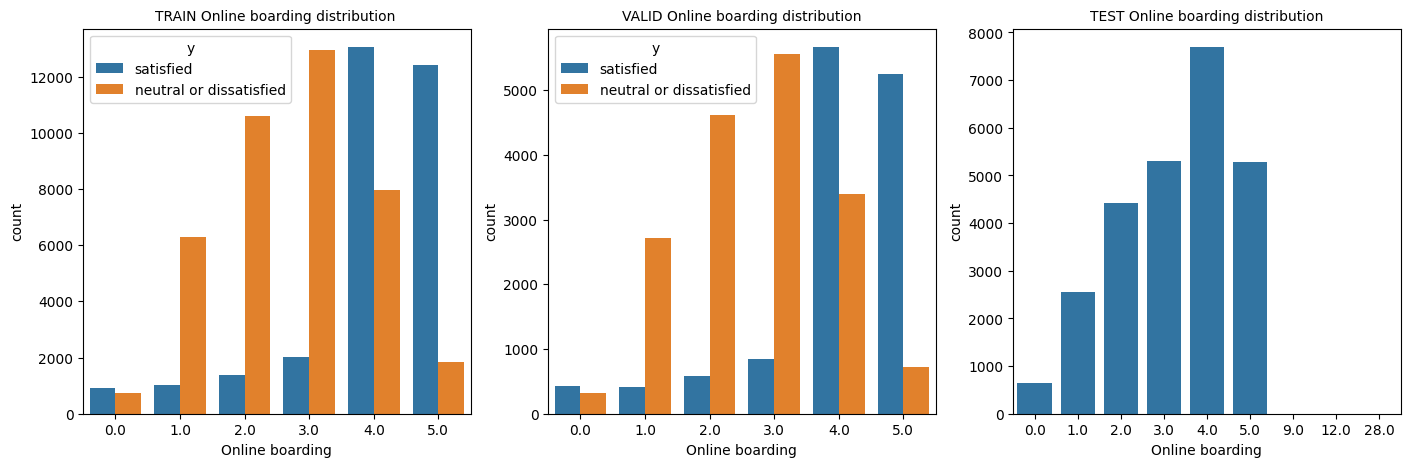

<Figure size 900x500 with 0 Axes>

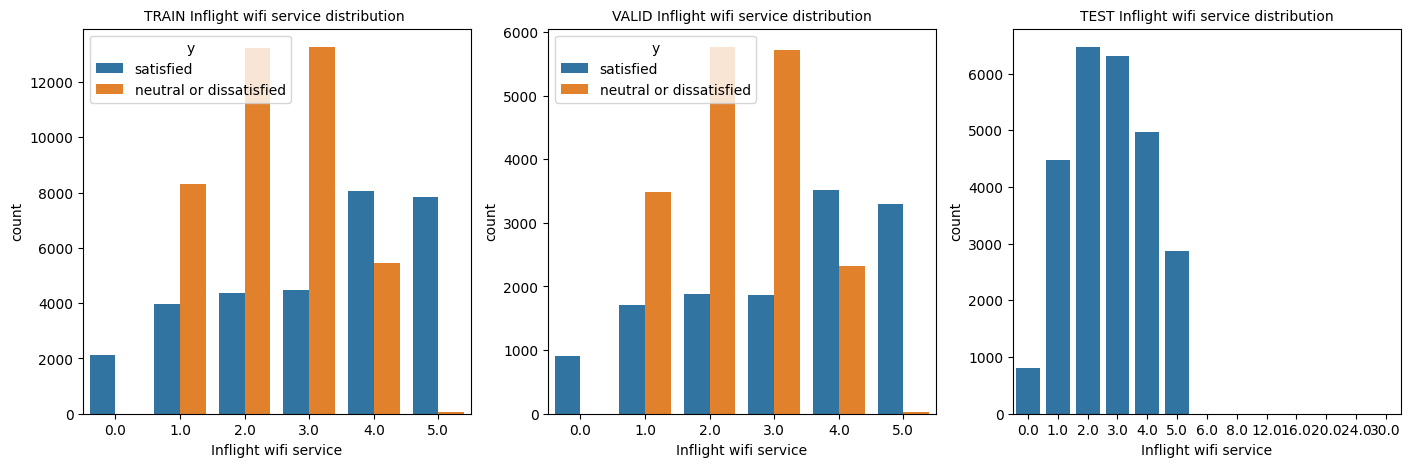

<Figure size 900x500 with 0 Axes>

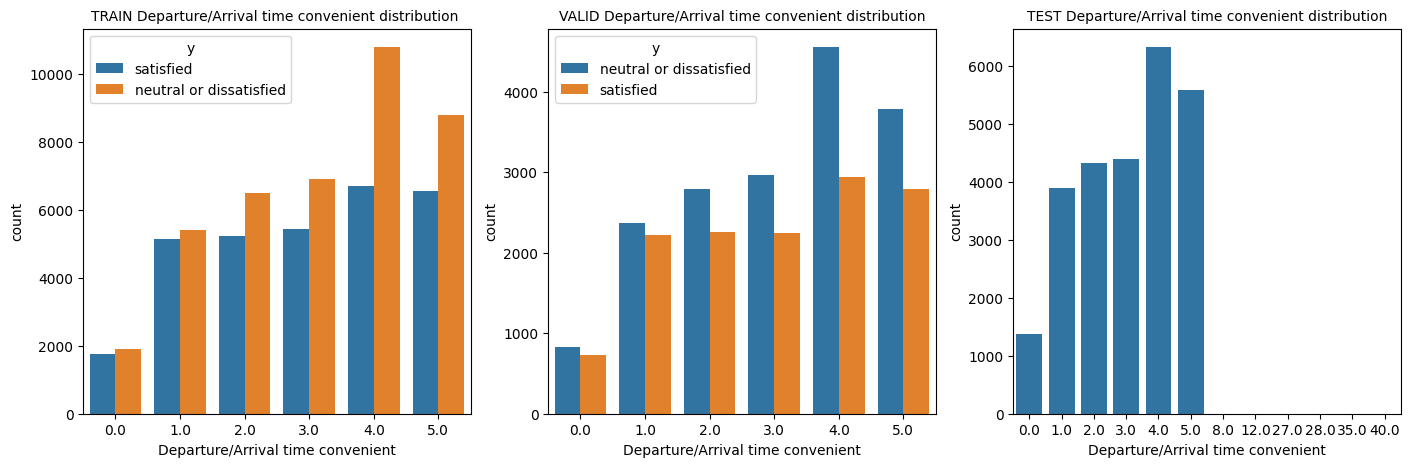

In [66]:
def plot_ordinal_comparison(cols, df, y, df_valid, y_valid, test):
    """Draws countplots for all columns in 'cols' with informative title"""
    for column in cols:
        plt.figure(figsize=(9, 5))
        fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize= [17, 5])
        plot = sns.countplot(df, x= column, hue= y, ax= axs[0])
        plot.set_title(f"TRAIN {column} distribution ", fontdict={'size': 10})

        plot = sns.countplot(df_valid, x= column, hue= y_valid, ax= axs[1])
        plot.set_title(f"VALID {column} distribution", fontdict={'size': 10})

        plot = sns.countplot(test, x= column, ax= axs[2])
        plot.set_title(f"TEST {column} distribution", fontdict={'size': 10})
        plt.show();


plot_ordinal_comparison(ordinal_cols, X_train, y_train, X_val, y_val, df_test)

Можно сказать, что распределения переменных в train, valid и test данных схожи.

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [67]:
X_train['Departure_Delay_log'] = np.log(X_train['Departure Delay in Minutes'] + 0.01)
X_train['Arrival_Delay_log'] = np.log(X_train['Arrival Delay in Minutes'] + 0.01)

X_val['Departure_Delay_log'] = np.log(X_val['Departure Delay in Minutes'] + 0.01)
X_val['Arrival_Delay_log'] = np.log(X_val['Arrival Delay in Minutes'] + 0.01)

In [68]:
continuous_cols.remove('Departure Delay in Minutes')
continuous_cols.remove('Arrival Delay in Minutes')

continuous_cols.append('Departure_Delay_log')
continuous_cols.append('Arrival_Delay_log')

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

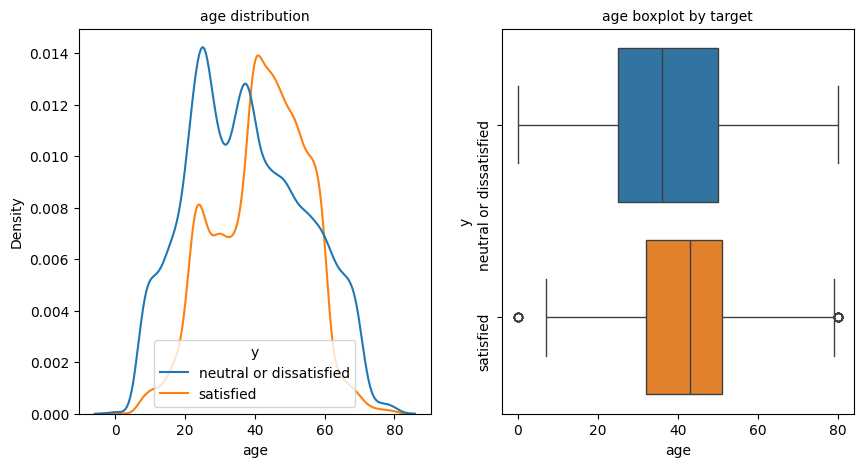

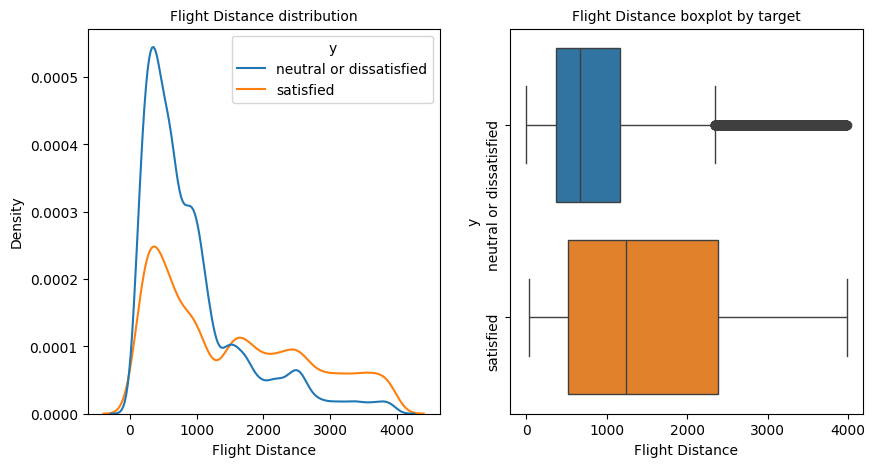

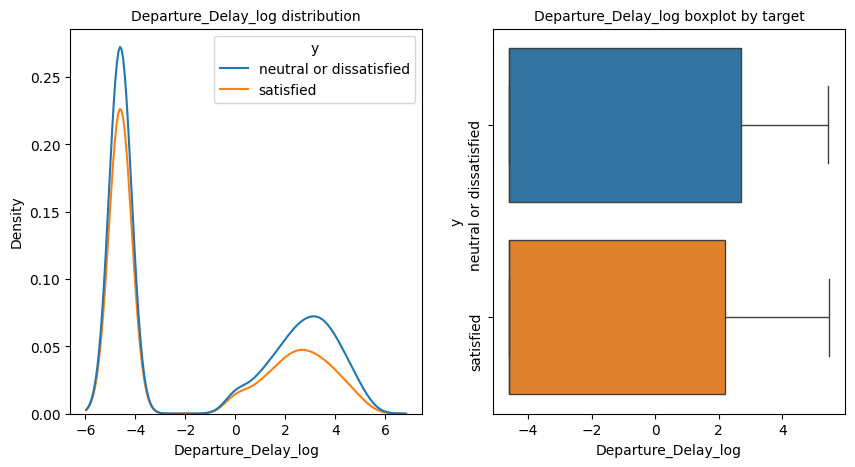

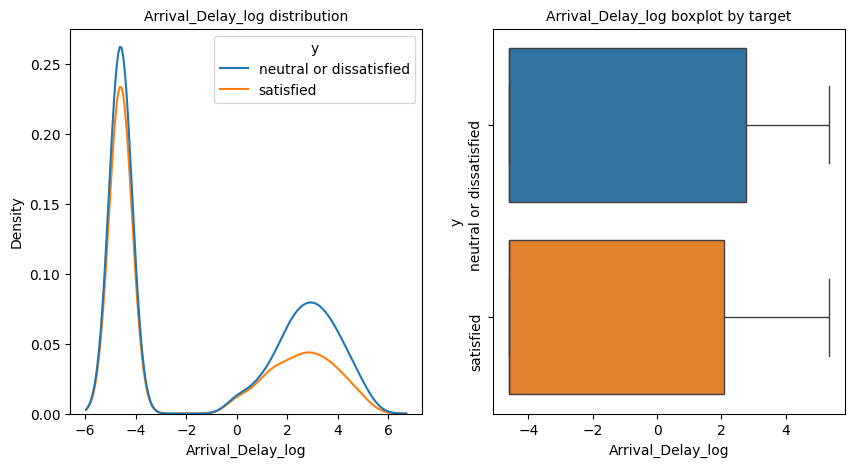

In [69]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [70]:
y_train = y_train.replace(['satisfied'], 1)
y_train = y_train.replace(['neutral or dissatisfied'], 0)

y_val = y_val.replace(['satisfied'], 1)
y_val = y_val.replace(['neutral or dissatisfied'], 0)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

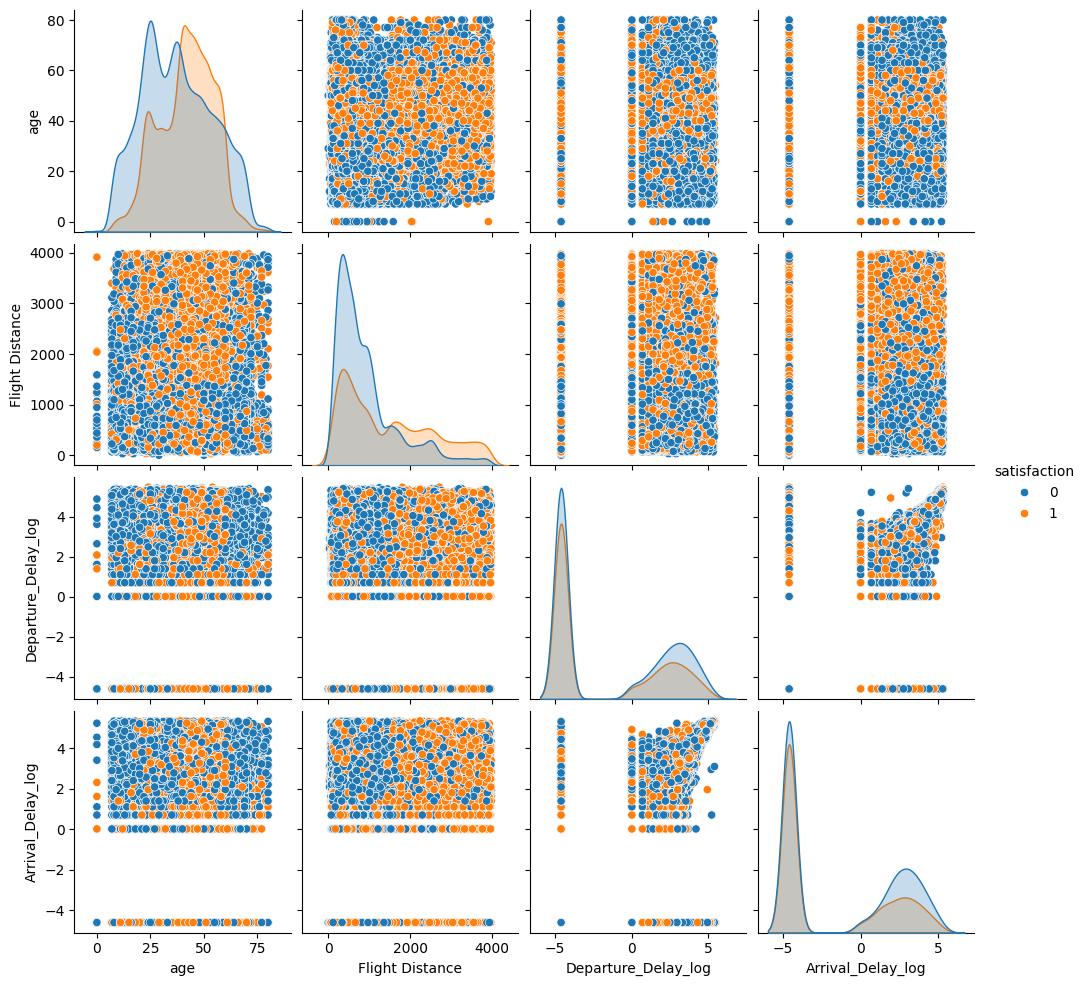

In [71]:
X_train_cont = X_train[continuous_cols]
X_train_cont['satisfaction'] = y_train
sns.pairplot(X_train_cont, hue='satisfaction');

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [72]:
encoder = OneHotEncoder(drop= 'first')

# Train data
transform_cat_data = encoder.fit_transform(X_train[categorical_cols])

cat_data = pd.DataFrame(transform_cat_data.toarray())
cat_data.columns = encoder.get_feature_names_out()

X_train.drop(categorical_cols, axis= 1, inplace= True)

# объединяю закодированные one-hot признаки с основным набором данных
X_train = pd.concat([X_train.reset_index(), cat_data], axis=1).set_index('id')

In [73]:
# Validate data
transform_cat_data = encoder.transform(X_val[categorical_cols])

cat_data = pd.DataFrame(transform_cat_data.toarray())
cat_data.columns = encoder.get_feature_names_out()

X_val.drop(categorical_cols, axis= 1, inplace= True)

X_val = pd.concat([X_val.reset_index(), cat_data], axis=1).set_index('id')

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [75]:
clf = DecisionTreeClassifier(random_state= 42)
clf.fit(X_train, y_train)

print("Train accuracy_score:", accuracy_score(y_train, clf.predict(X_train)))
print("Valid accuracy_score:", accuracy_score(y_val, clf.predict(X_val)))

Train accuracy_score: 1.0
Valid accuracy_score: 0.9436684372745754


## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [76]:
error_dt, bias_dt, var_dt = bias_variance_decomp(clf, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), loss='0-1_loss', random_seed= 42)

error_dt, bias_dt, var_dt

(0.06177290314118959, 0.04059282575906617, 0.045905633156272545)

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

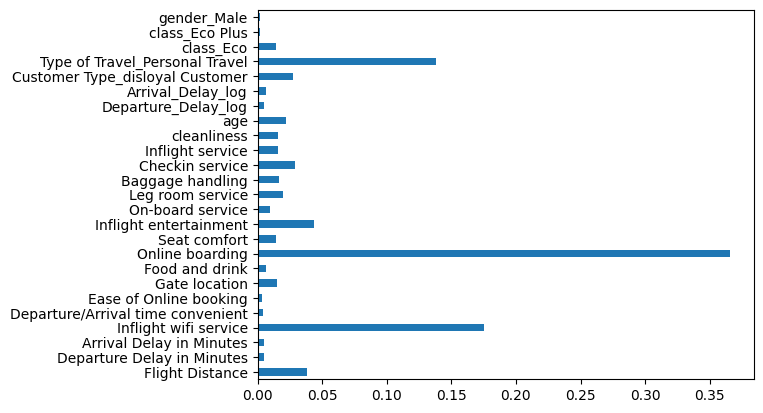

In [77]:
(pd.Series(clf.feature_importances_, index=X_train.columns)
   .plot(kind='barh'));

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

Явно выделяются по информативности от остальных признаков:
- Inflight service;
- Online boarding;
- Type of Travel_Personal Travel.

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [37]:
print('Глубина дерева:', clf.get_depth())
print('Количество листьев:', clf.get_n_leaves())

Глубина дерева: 33
Количество листьев: 2020


<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [38]:
clf_depth_5 = DecisionTreeClassifier(max_depth=5, random_state= 42)
clf_depth_5.fit(X_train[['Inflight service', 'Online boarding']], y_train)

print("Train accuracy_score:", accuracy_score(y_train, clf_depth_5.predict(X_train[['Inflight service', 'Online boarding']])))
print("Valid accuracy_score:", accuracy_score(y_val, clf_depth_5.predict(X_val[['Inflight service', 'Online boarding']])))

Train accuracy_score: 0.8090762205830699
Valid accuracy_score: 0.8126106629942947


Без остальных признаков качество значительно упало

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

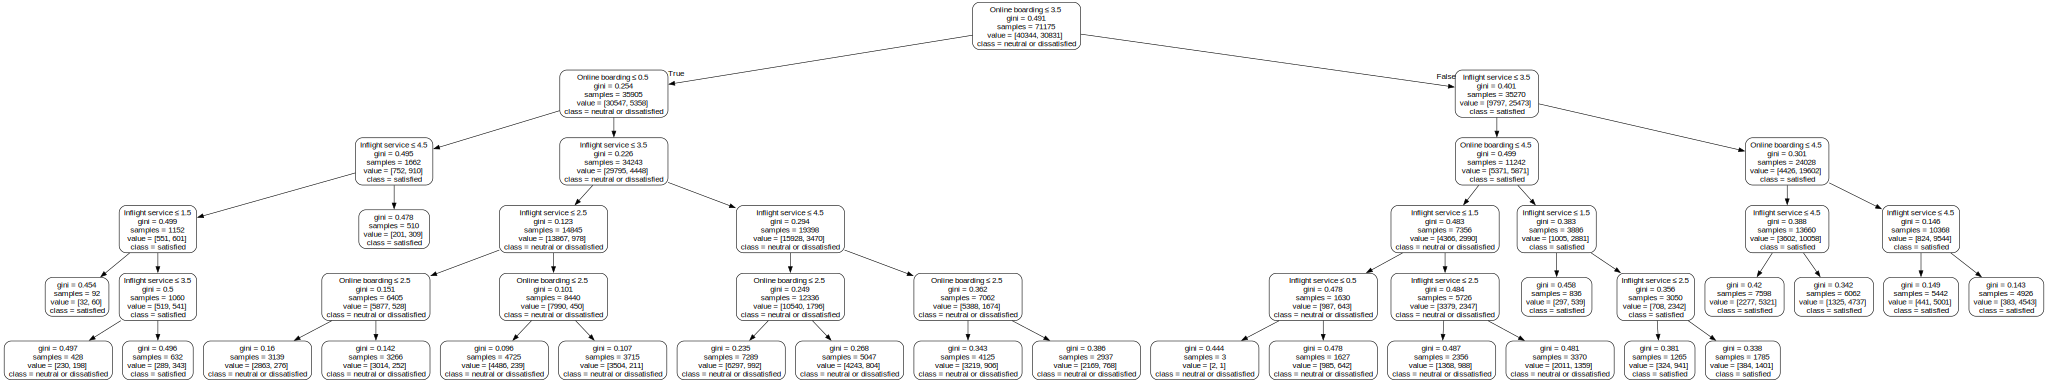

In [39]:
dot_data = export_graphviz(
    clf_depth_5, 
    feature_names= X_train[['Inflight service', 'Online boarding']].columns,
    class_names= ['neutral or dissatisfied', 'satisfied'],
    rounded=True,
    special_characters=True
    )  
Source(dot_data)

Предполагаю, потому что шаг поиска порога разделения предиката составляет 1/2

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

In [ ]:
clf_depth_5_cont = DecisionTreeClassifier(max_depth=5, random_state= 42)

clf_depth_5_cont.fit(X_train[['age', 'Flight Distance']], y_train)

print("Train accuracy_score:", accuracy_score(y_train, clf_depth_5_cont.predict(X_train[['age', 'Flight Distance']])))
print("Valid accuracy_score:", accuracy_score(y_val, clf_depth_5_cont.predict(X_val[['age', 'Flight Distance']])))

Train accuracy_score: 0.6782297154899894
Valid accuracy_score: 0.6835530198701554


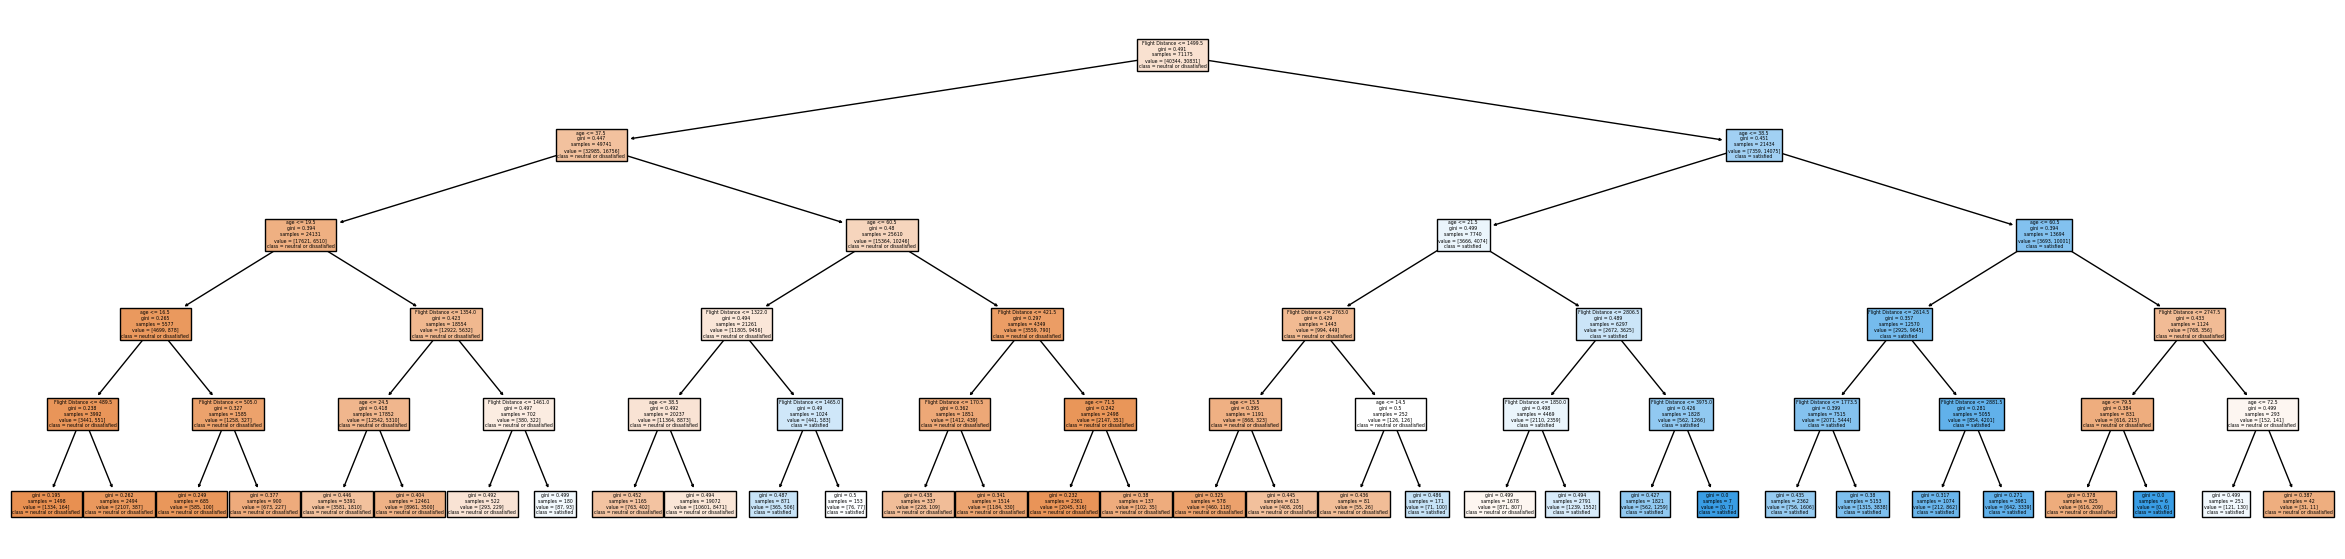

In [41]:
plt.figure(figsize=(30,7))
tree.plot_tree(
    clf_depth_5_cont, 
    feature_names= X_train[['age', 'Flight Distance']].columns,
    class_names= ['neutral or dissatisfied', 'satisfied'],
    filled=True
    );

Дерево получилось симметричным. Это хорошо в плане борьбы с переобучением, но в плане скорости работы это может оказаться минусом, если применять его на большом признаковом пространстве. 

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


<Axes: >

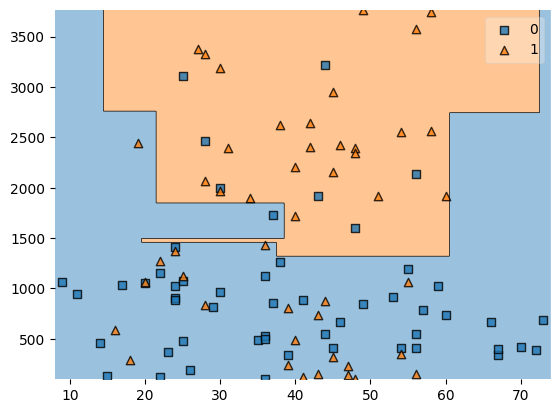

In [42]:
plot_decision_regions(np.array(X_val[['age', 'Flight Distance']][:100]), np.array(y_val[:100]), clf= clf_depth_5_cont)

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


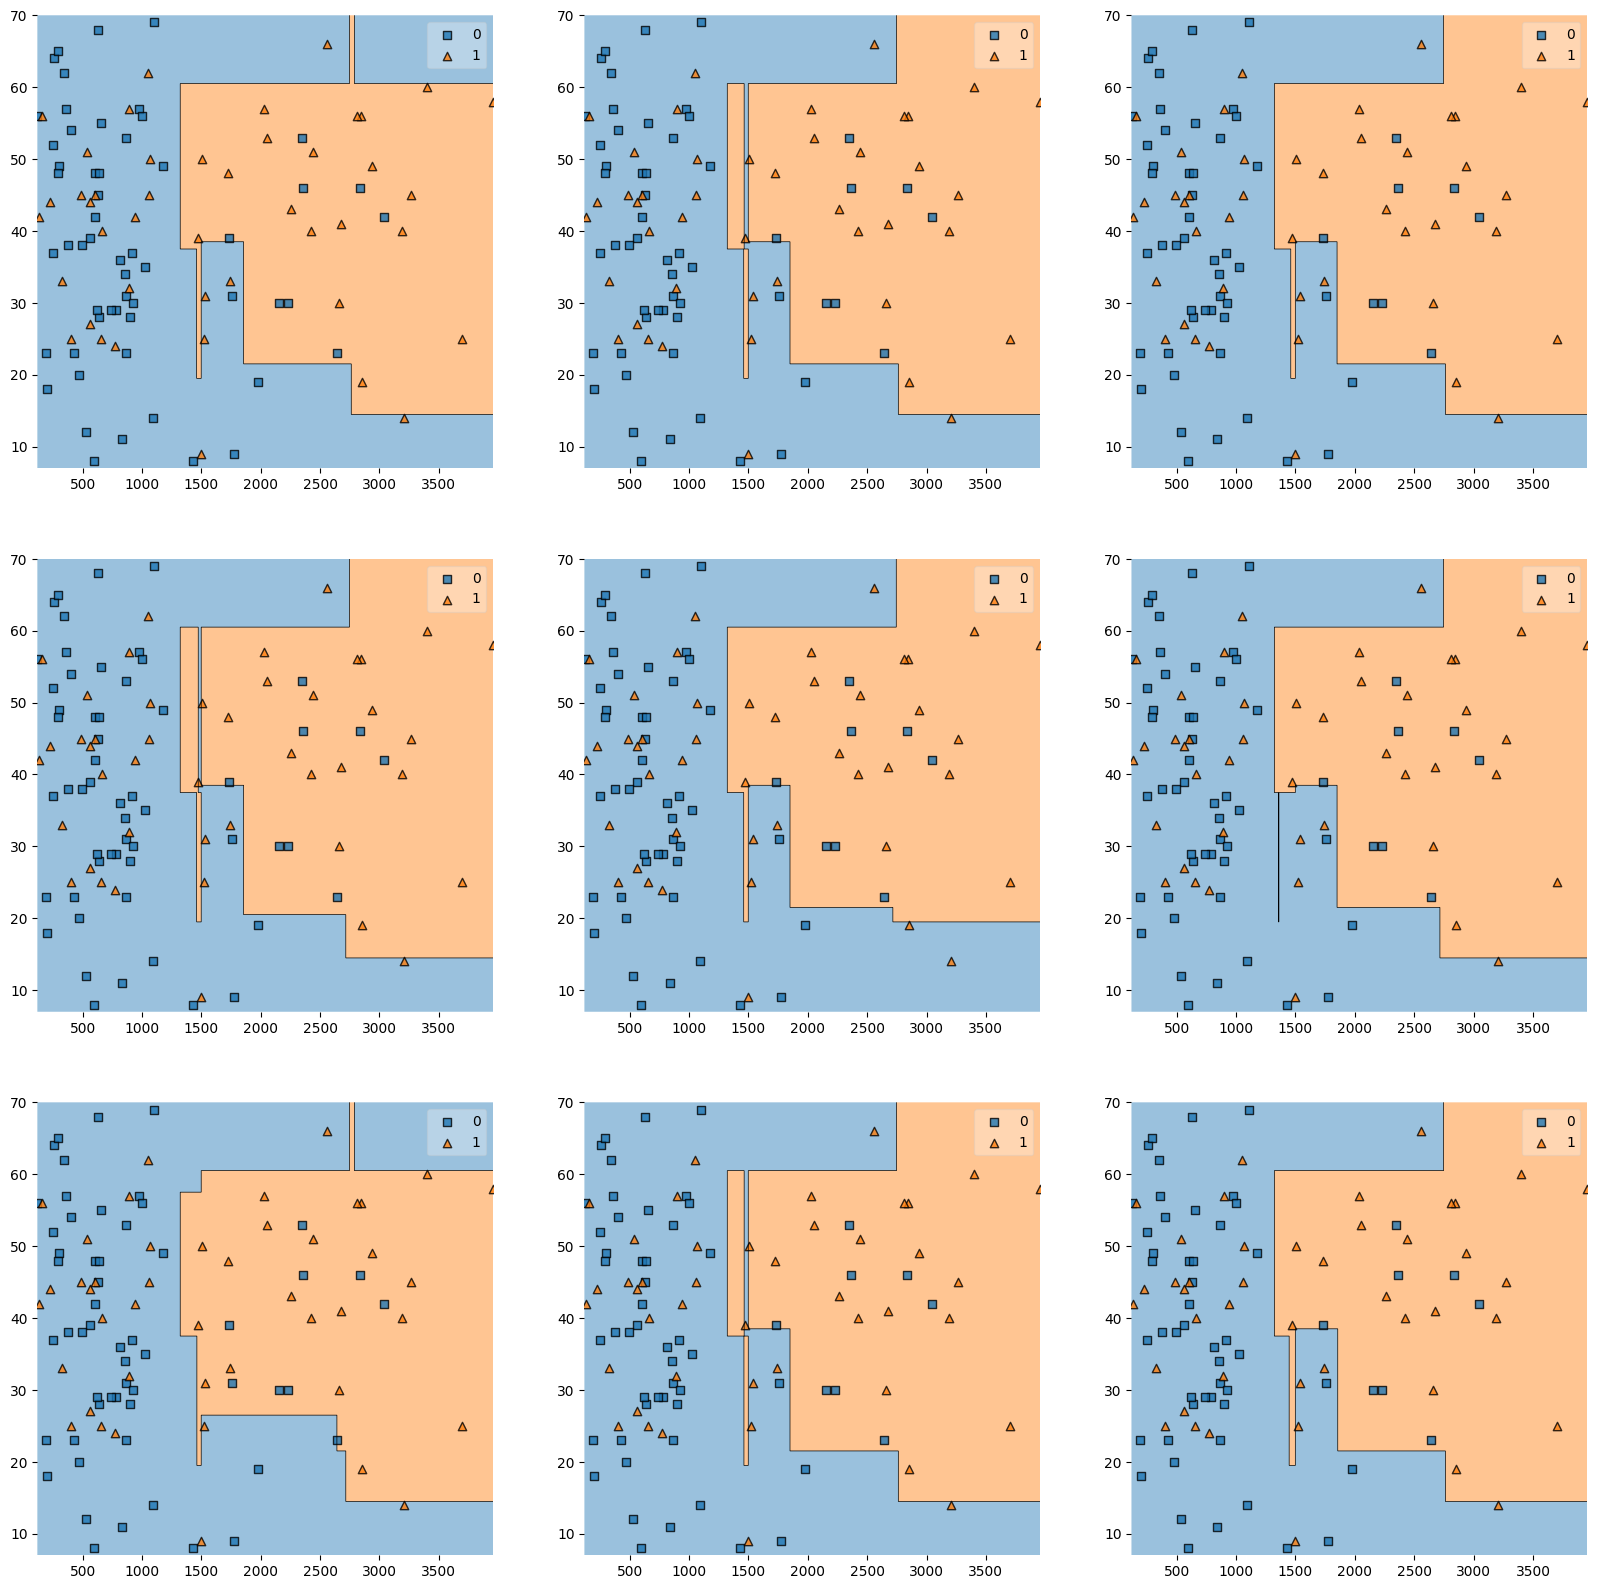

In [43]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train.index, size=X_train.shape[0] - 5000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train.loc[inds, ['Flight Distance', 'age']], y_train[inds])

        plot_decision_regions(clf= tree_exp, X= np.array(X_train.iloc[:100, [0,17]]), y= np.array(y_train[:100]), ax= ax[row][col]);

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [44]:
%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 3.03 s, sys: 33.2 ms, total: 3.07 s
Wall time: 3.09 s


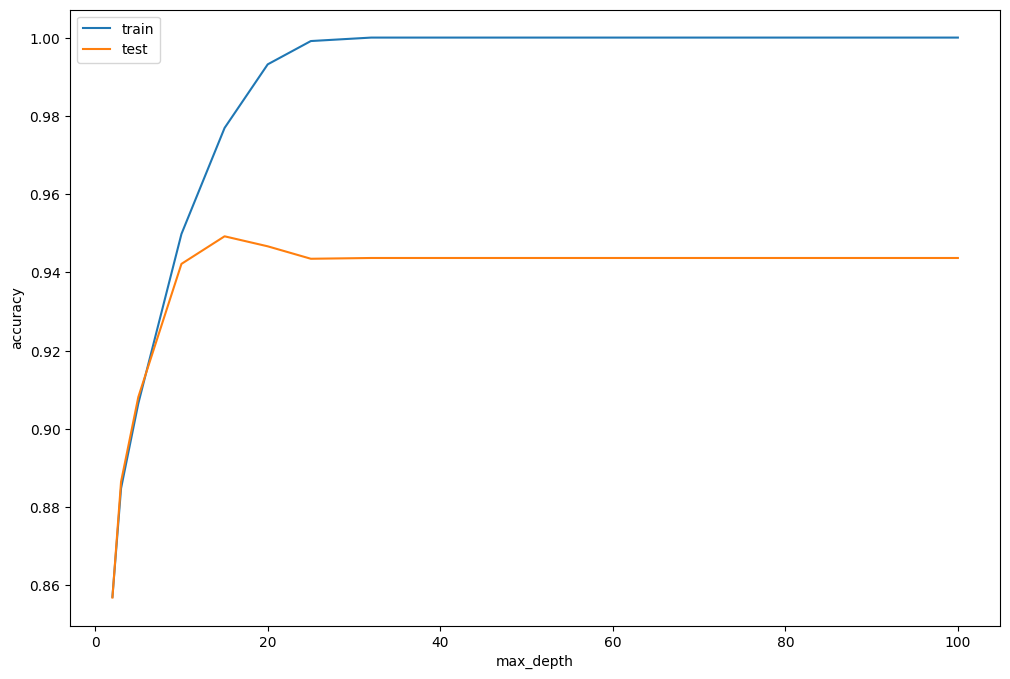

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [46]:
parametrs = {
    'criterion': ['gini', 'log_loss'],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [1, 5, 10]
    }

grid = GridSearchCV(clf, parametrs, cv= 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'log_loss'],
                         'max_depth': [2, 4, 6],
                         'min_samples_leaf': [1, 5, 10]})

In [47]:
print("Лучшие параметры:", grid.best_params_)
print('Лучшая оценка', grid.best_score_)

Лучшие параметры: {'criterion': 'log_loss', 'max_depth': 6, 'min_samples_leaf': 1}
Лучшая оценка 0.9216297857393748


<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [48]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(grid, f)

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [49]:
rf = RandomForestClassifier(n_jobs= -1, random_state= 42)
rf.fit(X_train, y_train)

print("Train accuracy_score:", accuracy_score(y_train, rf.predict(X_train)))
print("Valid accuracy_score:", accuracy_score(y_val, rf.predict(X_val)))

Train accuracy_score: 0.9999859501229365
Valid accuracy_score: 0.9610138369729162


(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

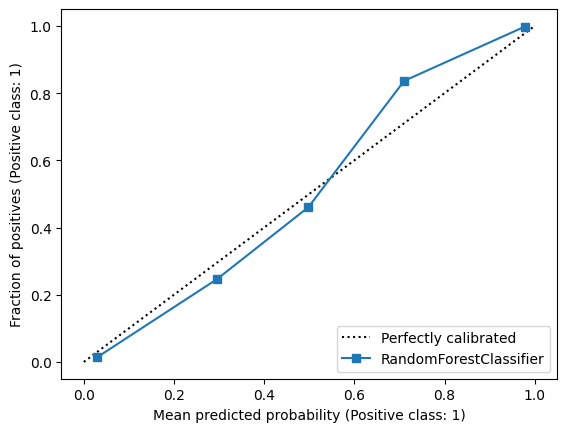

In [50]:
CalibrationDisplay.from_estimator(rf, X_val, y_val);

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

Да, деревья решений могут корректно предсказывать вероятности, так как разделяюшие правила формируются исходя из минимизации энтропии в листе. 

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

In [51]:
lr = LogisticRegression(max_iter= 1000, random_state= 42)

lr.fit(X_train, y_train)

print("Train accuracy_score:", accuracy_score(y_train, lr.predict(X_train)))
print("Valid accuracy_score:", accuracy_score(y_val, lr.predict(X_val)))

Train accuracy_score: 0.8664840182648402
Valid accuracy_score: 0.8678273985179356


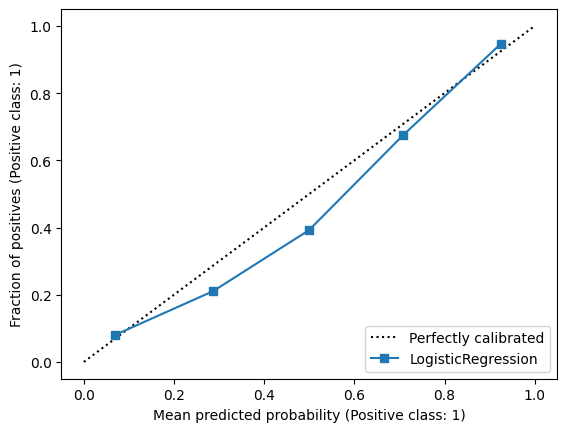

In [52]:
CalibrationDisplay.from_estimator(lr, X_val, y_val);

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Потому что в качестве функции ошибки используется logloss, который напрямую работает с вероятностями, т.е. в формуле logloss каждое слагаемое - это кроссэнтропия, которая минимальна при:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>&#x3C3;</mi>
  <mo stretchy="false">(</mo>
  <mo fence="false" stretchy="false">&#x27E8;</mo>
  <mi>w</mi>
  <mo>,</mo>
  <msub>
    <mi>x</mi>
    <mn>1</mn>
  </msub>
  <mo fence="false" stretchy="false">&#x27E9;</mo>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <msub>
    <mi>p</mi>
    <mn>0</mn>
  </msub>
  <mo>,</mo>
  <mstyle scriptlevel="0">
    <mspace width="1em"></mspace>
  </mstyle>
  <mn>1</mn>
  <mo>&#x2212;</mo>
  <mi>&#x3C3;</mi>
  <mo stretchy="false">(</mo>
  <mo fence="false" stretchy="false">&#x27E8;</mo>
  <mi>w</mi>
  <mo>,</mo>
  <msub>
    <mi>x</mi>
    <mn>1</mn>
  </msub>
  <mo fence="false" stretchy="false">&#x27E9;</mo>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <msub>
    <mi>p</mi>
    <mn>1</mn>
  </msub>
</math>

И если в признаковое пространство достаточно подробное, классы хорошо разделимы линейно, то и оценки получаются близки к истинной веротности. 

Материал взят из https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti

(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

X has feature names, but RandomForestClassifier was fitted without feature names


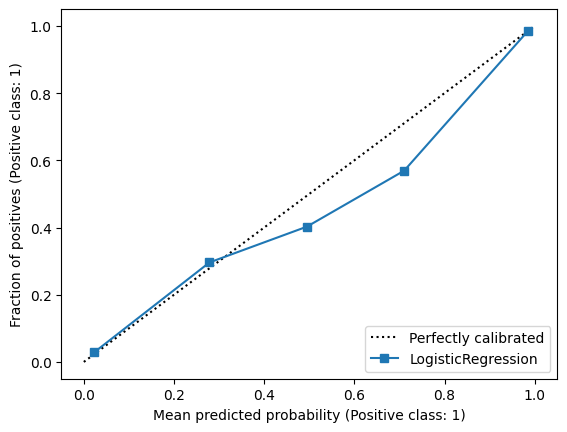

In [66]:
predict_proba_rf = rf.predict_proba(X_val)[:, 1]

logistic_regress = lr.fit(predict_proba_rf.reshape(-1, 1), y_val)
predict_logistic = logistic_regress.predict_proba(predict_proba_rf.reshape(-1, 1))[:, 1]

CalibrationDisplay.from_estimator(logistic_regress, predict_proba_rf.reshape(-1, 1), y_val);

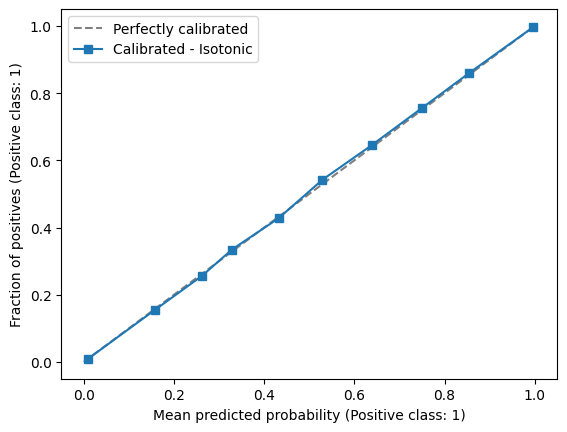

In [54]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

predict_proba_rf = rf.predict_proba(X_val)[:, 1]

clf_sigmoid = CalibratedClassifierCV(rf, cv= 10, method= 'isotonic')
clf_sigmoid.fit(predict_proba_rf.reshape(-1, 1), y_val)

y_test_predict_proba = clf_sigmoid.predict_proba(predict_proba_rf.reshape(-1, 1))[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_test_predict_proba, n_bins=10)

plt.plot([0, 1], [0, 1], '--', color= 'gray', label= 'Perfectly calibrated')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label= 'Calibrated - Isotonic')
plt.xlabel('Mean predicted probability (Positive class: 1)')
plt.ylabel('Fraction of positives (Positive class: 1)')
plt.legend();

Получена идеально откалиброванная модель

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

https://alexanderdyakonov.wordpress.com/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/

1) Непараметрический метод гистограммной калибровки (Histogram Binning) - отрезок [0, 1] разбивается на бины и стремимся к тому, что бы на каждом бине алгоритм предсказывал одну и ту же вероятность, благодаря подбору средних меток класса в бине.
2) Параметрическая калибровка Платта (Platt calibration) - заключается в применении сигмоиды поверх другой модели, преимущественно над SVM. (https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti)
3) Деревья калибровки (Probability calibration trees) - в этом алгоритме строится дерево решений, а в листах обучается линейная регрессия на одном признаке (подробно разбирается в этом видео- https://www.youtube.com/watch?v=IL7sWMOazXQ)

(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [56]:
error_dt, bias_dt, var_dt = bias_variance_decomp(rf, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), loss='0-1_loss', random_seed= 42)

error_dt, bias_dt, var_dt

(0.04079710144927537, 0.03885500688569742, 0.009422585087546724)

(0.06177290314118959, 0.04059282575906617, 0.045905633156272545) - ошибка, смещение и разброс соответственно для дерева решений. Видим, что разброс значительно меньше у случайного леса - это ожидаемое значение, так как бэггинг помогает уменьшать разброс ошибки алгоритма. 

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [57]:
error_dt, bias_dt, var_dt = bias_variance_decomp(lr, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), loss='0-1_loss', random_seed= 42)

error_dt, bias_dt, var_dt

(0.13323709751459112, 0.13230375762345073, 0.011450095088202506)

Для логистической регрессии результаты ожидаемые: высокое смещение ошибок алгоритма, но низкий разброс, так как логистическая регрессия - простая модель и не выучивает все закономерности данных, но при этом ее ответы имеею наименьший разброс.

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [58]:
from scipy.stats import  uniform

distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': [7, 8, 9],
    'max_samples': uniform(0, 1)
    }

rsCV = RandomizedSearchCV(rf, distributions, random_state= 42)
search = rsCV.fit(X_train, y_train)

print("Лучшие параметры:", search.best_params_)
print('Лучшая оценка', search.best_score_)


Лучшие параметры: {'max_depth': 9, 'max_samples': 0.45606998421703593, 'n_estimators': 200}
Лучшая оценка 0.9403582718651211


## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [59]:
cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]

# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки
rf_clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    rf_clf.set_params(n_estimators=n_estimators)
    rf_clf.fit(X_train_RF, y_train)

    errors.append(1 - rf_clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


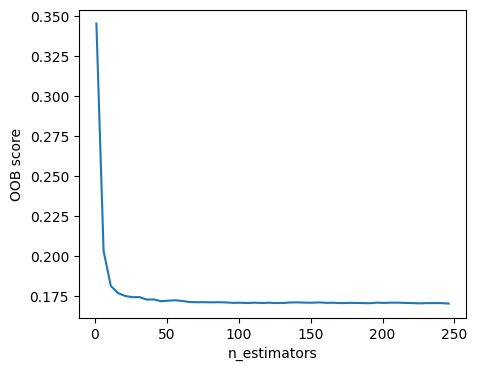

In [60]:
plt.figure(figsize=(5, 4))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

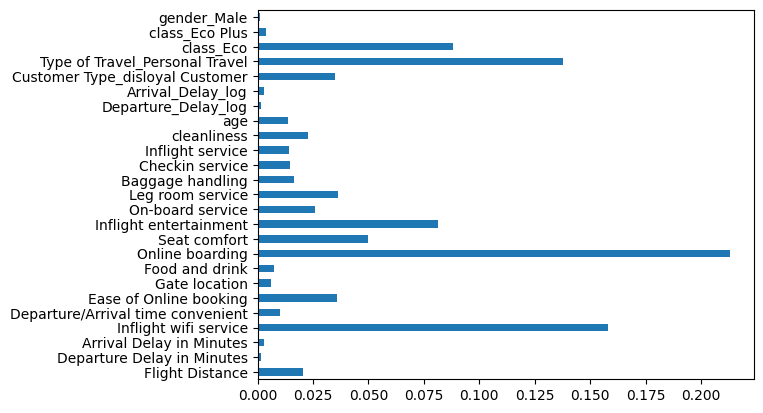

In [61]:
rf_rcv = RandomForestClassifier(max_depth= 9, max_samples= 0.45606998421703593, n_estimators= 200, n_jobs=-1, random_state=42)
rf_rcv.fit(X_train, y_train)

(pd.Series(rf_rcv.feature_importances_, index=X_train.columns).plot(kind='barh'));

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

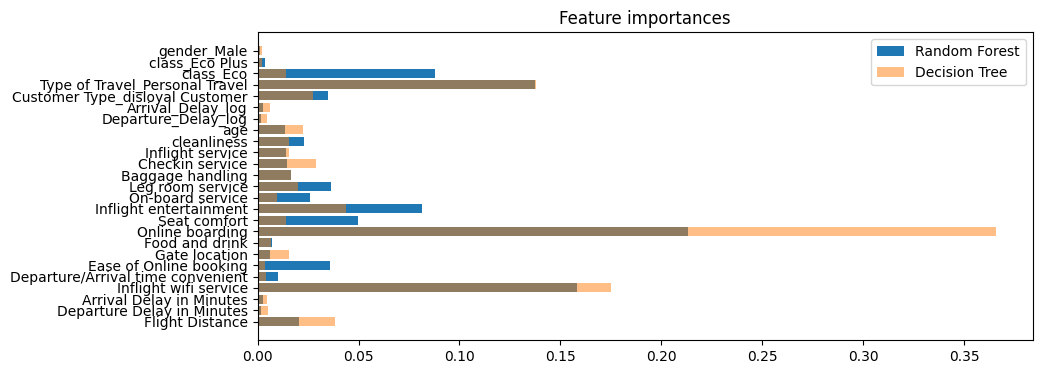

In [62]:
plt.figure(figsize= (10, 4))
plt.title('Feature importances')
plt.barh( X_train.columns, rf_rcv.feature_importances_, label= 'Random Forest')
plt.barh( X_train.columns, clf.feature_importances_, alpha= 0.5, label= 'Decision Tree')
plt.legend()
plt.show()

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

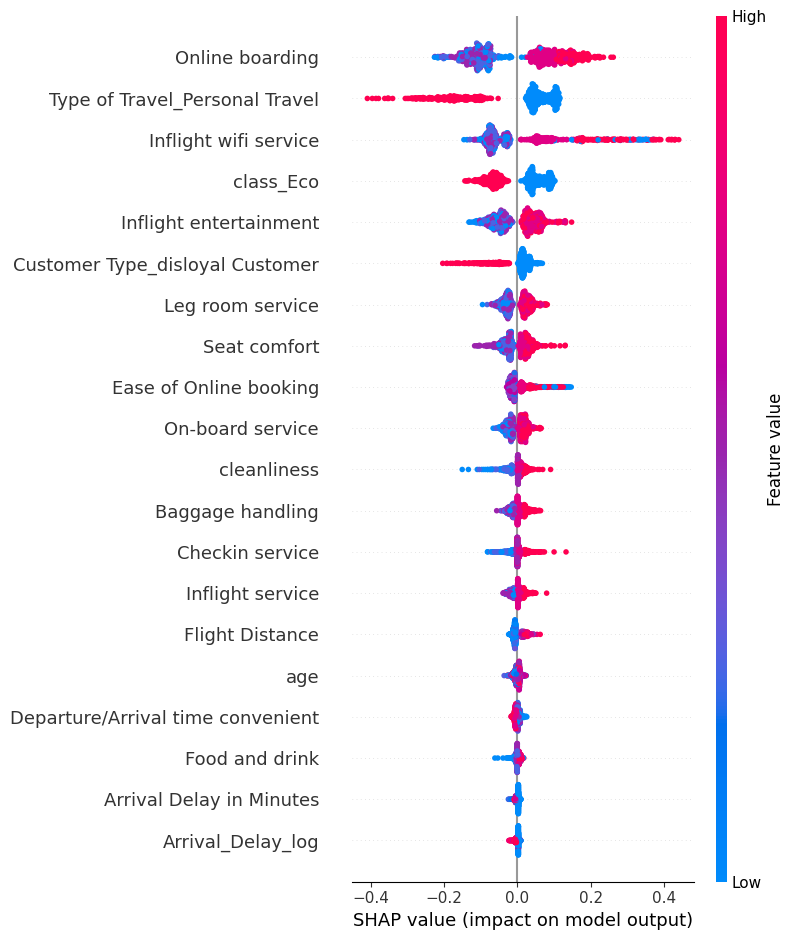

In [63]:
explainer = shap.Explainer(rf_rcv)
shap_values = explainer(X_train[:1000])
shap.summary_plot(shap_values[:,:,1], X_train[:1000])

<font color='#FF6600'>Опишите полученый график</font>

На графике признаки сортируются по убыванию среднего абсолютного значения коэффициента Шапли для этого признака по всем наблюдениям и отображается распределение влияния каждого признака на выходные данные модели, значения слева от центральной вертикальной линии — это класс 0, справа — класс 1, чем краснее точки, тем большее значение имеет признак в этой точке. Из этого графика можно сказать, что наибольшее влияние на ответ модели оказывает признак "Online boarding", что согласуется с данными полученными от feature importances модели.

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

Помимо изображения важности признаков по коэффициенту Шепли, библиотека позволяет:
- отобразить график зависимости изменение значений SHAP в диапазоне значений признака;
- изображать выбросы в данных; 
- сравнивать несколько моделей между собой;
- изобразить взаимосвязь значений наблюдений признака и значение коэфф., Шепли этого признака; 

и многое другое

In [64]:
random.seed(42)

explainer = LimeTabularExplainer(
    X_train.values, 
    mode= "classification",
    class_names= ['neutral or dissatisfied', 'satisfied'],
    feature_names= X_train.columns.tolist()
    )

idx = random.randint(1, len(X_val))
explanation = explainer.explain_instance(X_val.values[idx], 
                                         rf_rcv.predict_proba,
                                         num_features= 9)

explanation.show_in_notebook();

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<font color='#FF6600'>Опишите полученый график</font>

Полученный график помогает понять что именно влияет на появление того или иного ответа исходной модели, тем самым помогает немного приоткрыть "черный ящик". График описывает вероятность получить тот или иной класс, самый значимый вклад 9-ти переменных (параметр num_features в explain_instance) в ответ модели.

<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

In [65]:
with open('random_forest.pkl', 'wb') as f:
    pickle.dump(rf_rcv, f)

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Объемная и многоохватывающая домашка, мне понравилось =) Попробовал множество инструментов объяснения ответов сложных моделей. Особенно помогли теоритические вопросы для глубокого понимания происходящего - заставляло дополнительно погуглить и посмотреть лекции с объяснениями. 